## COMP-553DL: Data Science for Bioinformatics and Medicine
## Programming Assignment 1 (Spring Semester 2025)
### Author: Ioannis Stathakis

####

### Part 2: Exploratory Data Analysis (EDA)

#### We will further explore the data, to reveal correlations, relationships and other insights that might be contained.
#### In this phase we will also decide on the best features to be used for modelling, and finally prepare the data for that last phase.

In [1]:
# Lets start by importing various necessary modules and libraries
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

In [2]:
# Import the previously cleaned dataset into a dataframe
main_df = pd.read_csv("cleaned_cervical_cancer_data.csv", header=[0])
main_df.head()

Age  Number Of Sexual Partners  First Sexual Intercourse  \
0   18                          4                        15   
1   15                          1                        14   
2   34                          1                        17   
3   52                          5                        16   
4   46                          3                        21   

   Number of Pregnancies  Smokes  Smokes (Years)  Smokes (Packs/Year)  \
0                      1       0             0.0                  0.0   
1                      1       0             0.0                  0.0   
2                      1       0             0.0                  0.0   
3                      4       1            37.0                 37.0   
4                      4       0             0.0                  0.0   

   Hormonal Contraceptives  Hormonal Contraceptives (Years)  IUD  ...  \
0                        0                              0.0    0  ...   
1                        0                              0.0    0  ...   
2                        0                              0.0    0  ...   
3                        1                              3.0    0  ...   
4                        1                             15.0    0  ...   

   Stds:Vulvo-Perineal Condylomatosis  Stds:Number Of Diagnosis  Dx:Cancer  \
0                                   0                         0          0   
1                                   0                         0          0   
2                                   0                         0          0   
3                                   0                         0          1   
4                                   0                         0          0   

   Dx:CIN  Dx:HPV  Dx  Hinselmann  Schiller  Citology  Biopsy  
0       0       0   0           0         0         0       0  
1       0       0   0           0         0         0       0  
2       0       0   0           0         0         0       0  
3       0       1   0           0         0         0       0  
4       0       0   0           0         0         0       0  

[5 rows x 24 columns]

####

### 1) Dataset Overview
#### Lets check out some basic characteristics and basic statistics for the dataset, like dimensions, column types, etc.

In [3]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 830 non-null    int64  
 1   Number Of Sexual Partners           830 non-null    int64  
 2   First Sexual Intercourse            830 non-null    int64  
 3   Number of Pregnancies               830 non-null    int64  
 4   Smokes                              830 non-null    int64  
 5   Smokes (Years)                      830 non-null    float64
 6   Smokes (Packs/Year)                 830 non-null    float64
 7   Hormonal Contraceptives             830 non-null    int64  
 8   Hormonal Contraceptives (Years)     830 non-null    float64
 9   IUD                                 830 non-null    int64  
 10  IUD (Years)                         830 non-null    float64
 11  Stds                                830 non-n

####

### 2) Target Variables Analysis
#### Lets focus on the target variables: Hinselmann, Schiller, Citology	and Biopsy.
#### These are all binary features, which means we need to check out the balance/imbalance of each, perhaps using visualizations as well.

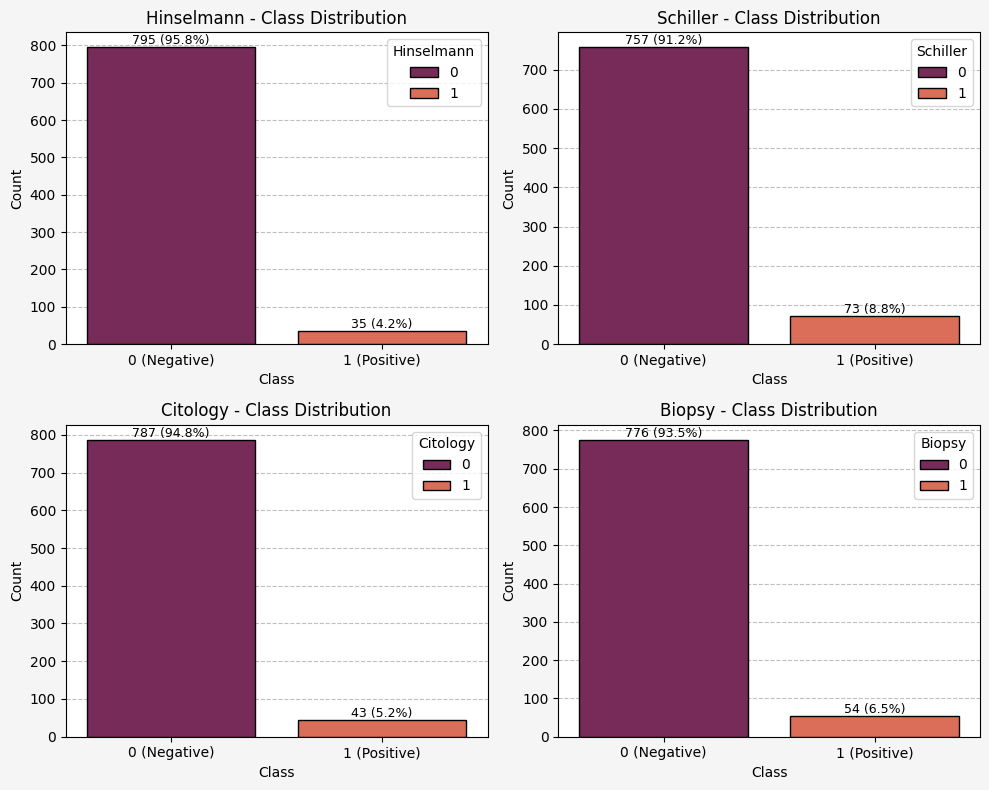

In [4]:
# Lets check out the class distribution for each target
# List of target variables
target_vars = ['Hinselmann', 'Schiller', 'Citology', 'Biopsy']

# Set up 2x2 grid for countplots
# This will ensure easier reading and comparisons
fig, axes = plt.subplots(2, 2, figsize=(10, 8), facecolor="whitesmoke")
axes = axes.flatten()

# Loop through each target and plot the distributions with annotations
for i, col in enumerate(target_vars):
    # Count values and calculate %
    count = main_df[col].value_counts()
    percent = main_df[col].value_counts(normalize=True) * 100

    # Create countplot
    ax = sns.countplot(x=main_df[col], hue=main_df[col], palette="rocket", ax=axes[i], edgecolor="black", zorder=2)
    ax.set_title(f"{col} - Class Distribution")
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["0 (Negative)", "1 (Positive)"])
    ax.grid(axis="y", linestyle="--", alpha=0.8, zorder=0)

    # Annotate each bar with count and percentage
    for p in ax.patches:
        if p.get_height() > 0:
            value = int(p.get_height())
            pct = value / len(main_df) * 100
            ax.annotate(f"{value} ({pct:.1f}%)",
                        (p.get_x() + p.get_width() / 2, p.get_height()),
                        ha='center', va='bottom', fontsize=9, color='black')
            
plt.tight_layout()
plt.show()


####

#### We can notice great class imbalances in all four target variables, as was already evident from the cleaning phase in Part 1.
#### This is indicative of a few things:
#### 1) Baseline Accuracy is misleading! A classifier could predict only 0s and still get >90% accuracy. We might need to rely on other metrics, such as Recall, F1-Score, Precision and AUC-ROC.
#### 2) Classifier Bias towards Majority Class: Most classifiers (Logistic Regression, Decision Trees, etc) will lean towards predicting 0s unless we intervene.
#### 3) Imbalance Handling Required: We will probably need to apply oversampling (SMOTE), class weighting or ensemble methods.

####

### 3) Feature Distributions Analysis
#### We will explore the various distributions of our continuous variables (histograms + KDE) and compare distributions by target subclasses for the four targets.

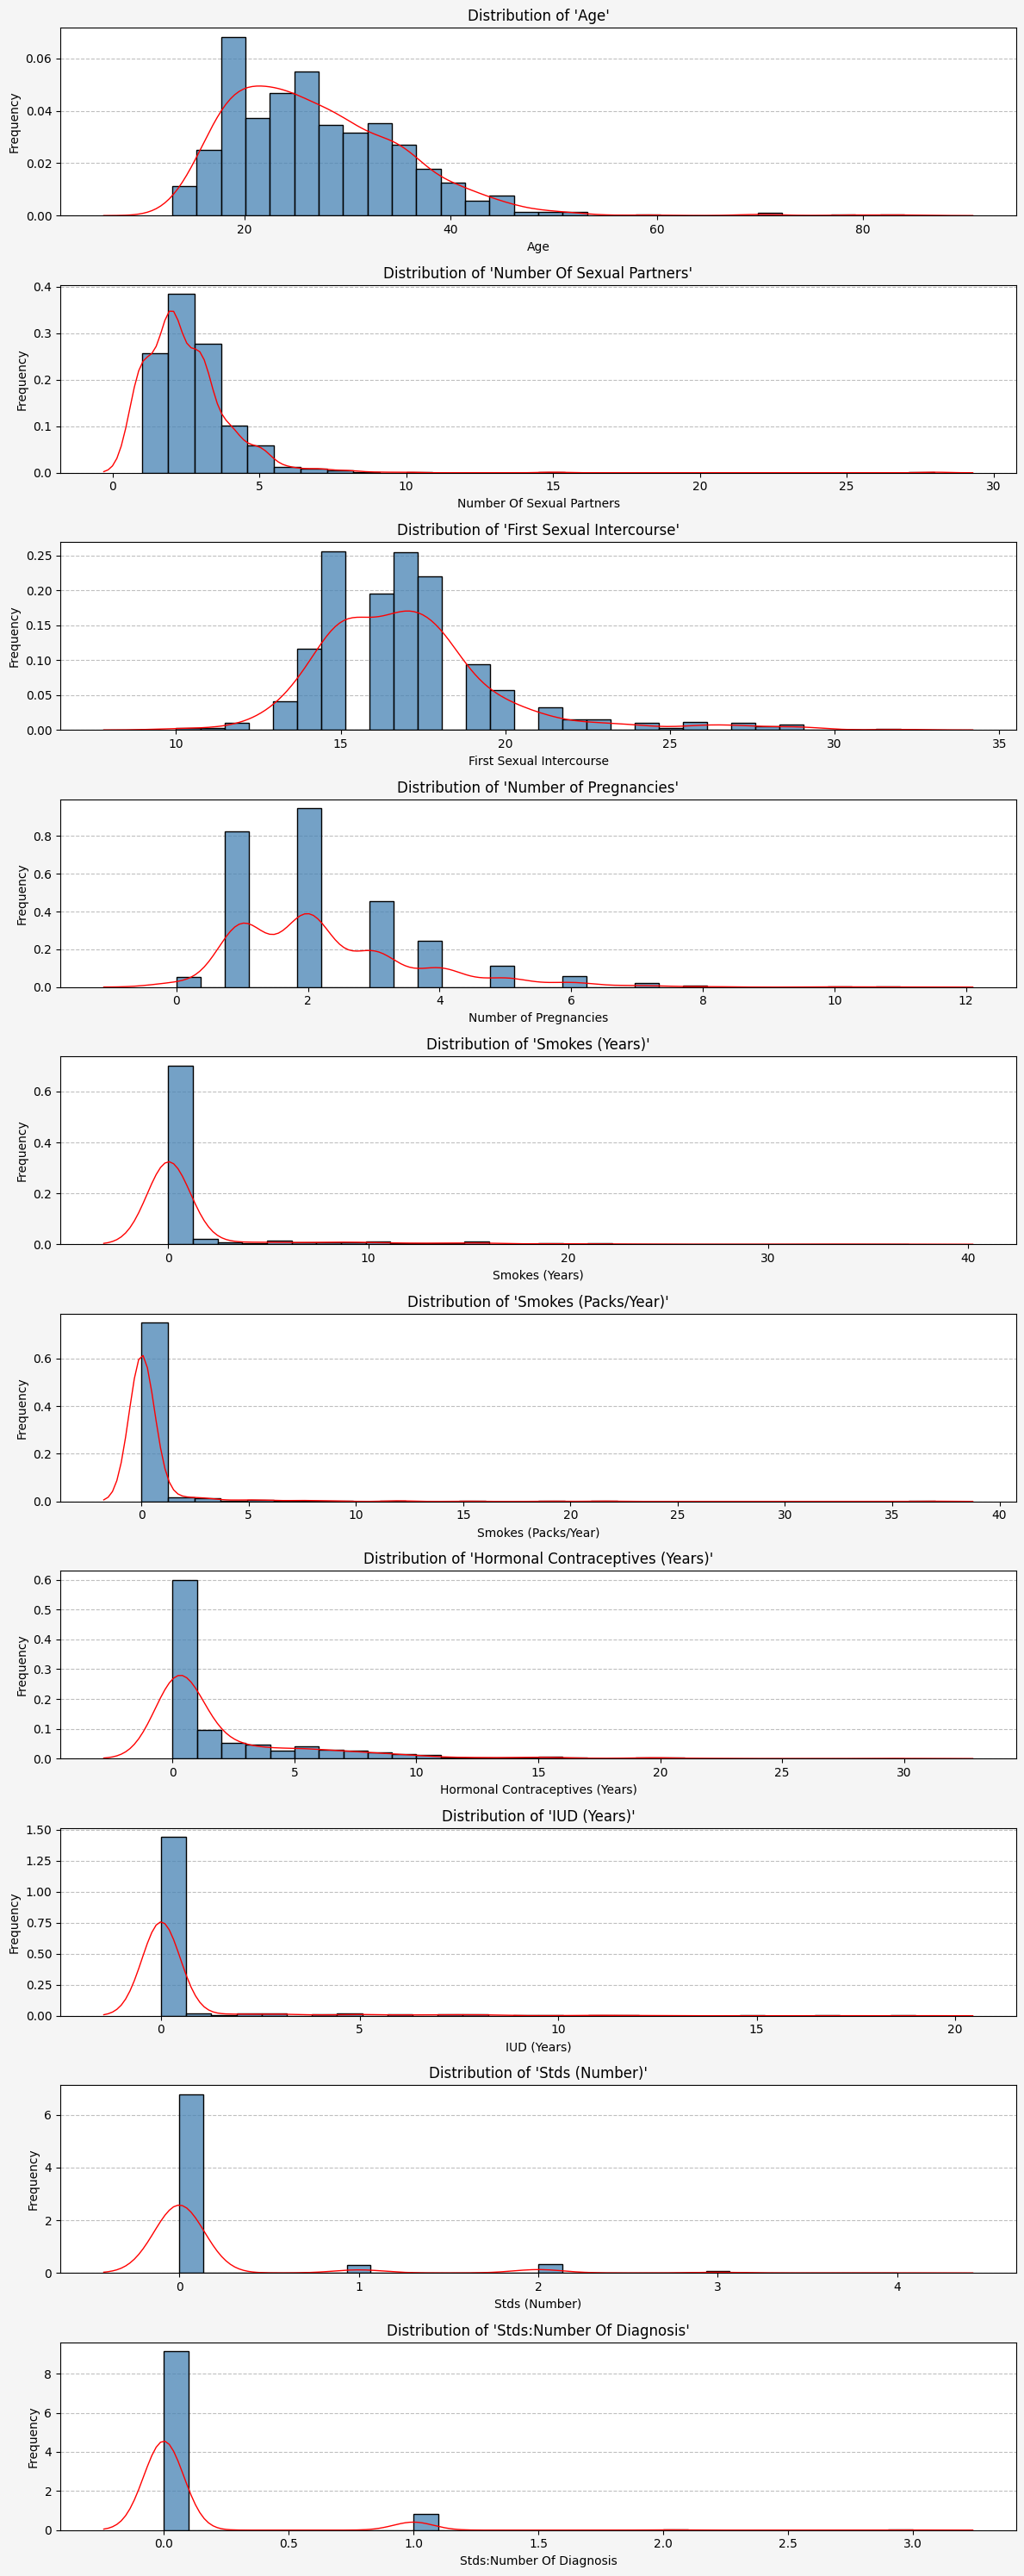

In [5]:
# Select only non-binary features (more than 2 unique values)
# This is a fast way to include all these features without specifically defining all the columns separately
non_binary_features = [col for col in main_df.columns if main_df[col].nunique() > 2]

# Plot histograms with KDEs for more concise comparisons
plt.figure(figsize=(12, len(non_binary_features) * 3), facecolor="whitesmoke")

for i, col in enumerate(non_binary_features, 1):
    plt.subplot(len(non_binary_features), 1, i)
    sns.histplot(main_df[col], bins=30, kde=False, color="steelblue", stat="density", zorder=2) # Histogram scaled to match the KDE
    sns.kdeplot(main_df[col], color="red", linewidth=1) # Separate KDE generation so we can play around with the color and thickness!
    plt.title(f"Distribution of '{col}'")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.8, zorder=0)

plt.tight_layout()
plt.show()


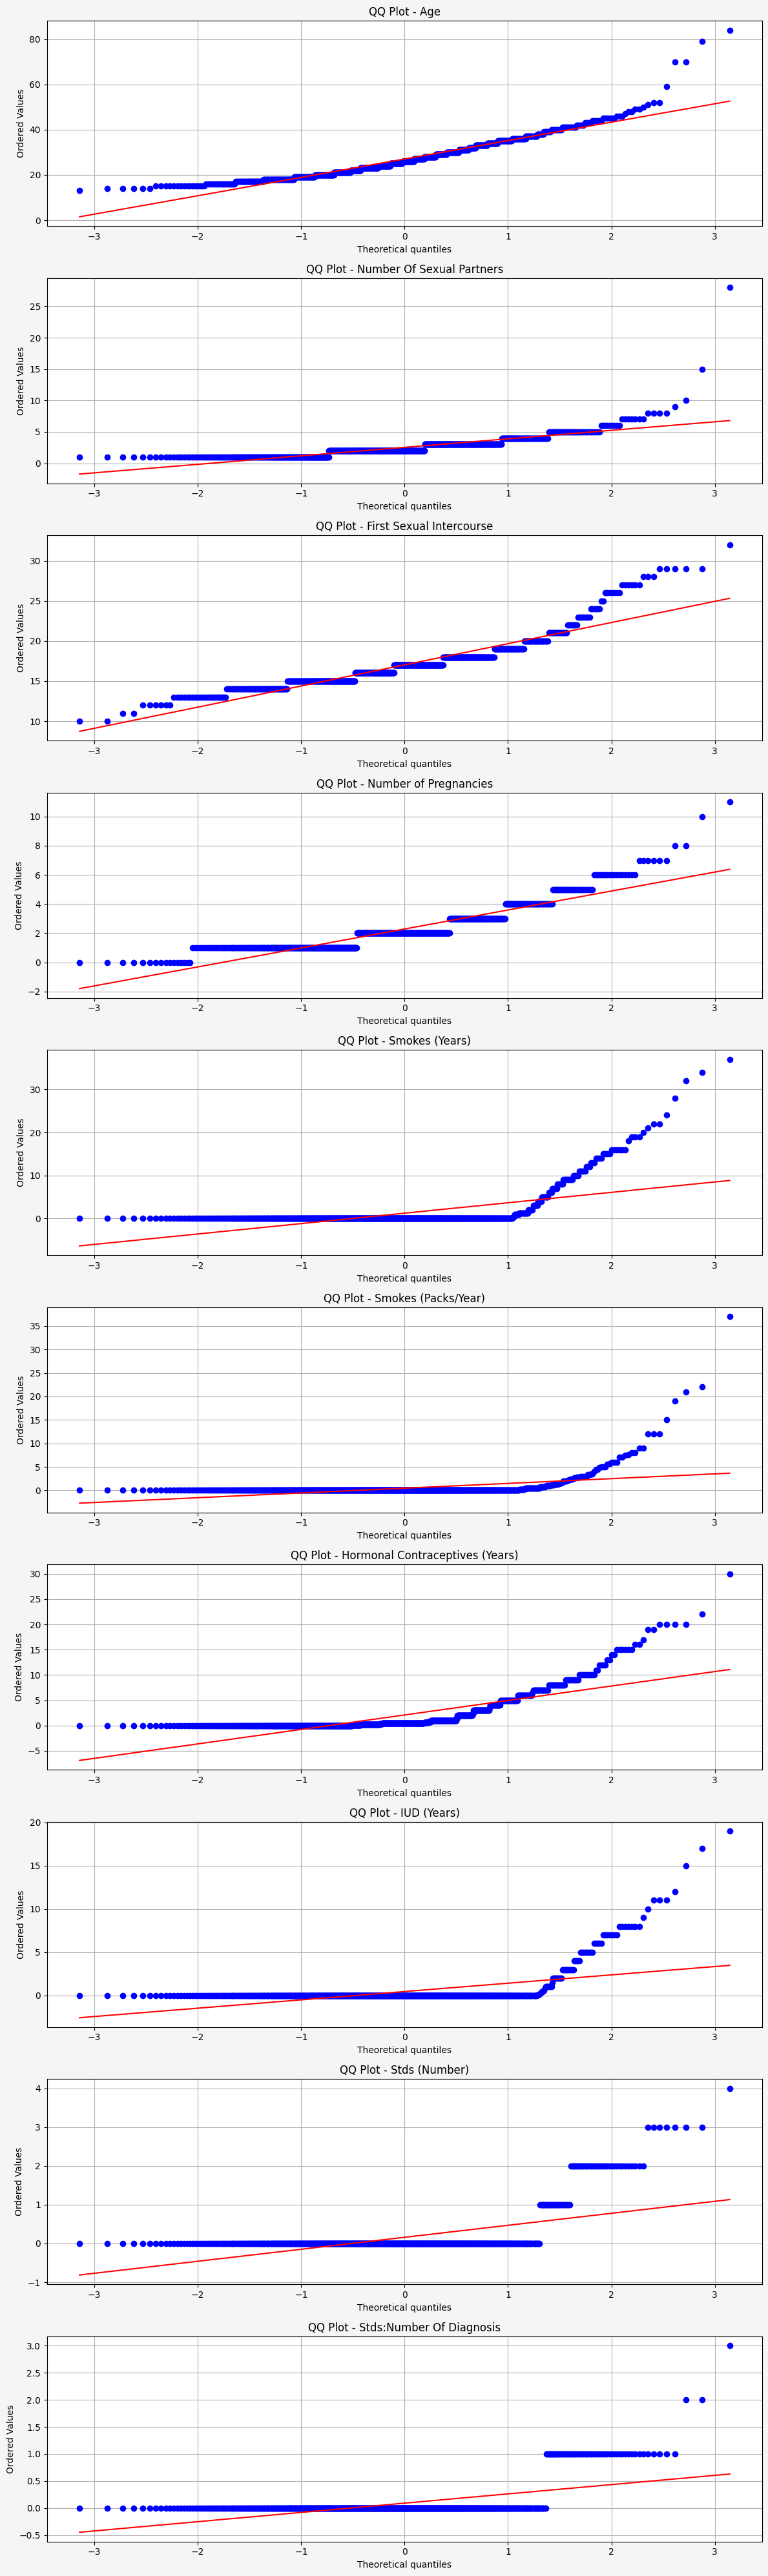

In [6]:
# We can notice skewed distributions in all features
# Lets try some QQ-plots to test for normality of these features (especially the less discrete ones)
# Discrete features with fewer unique values will obviously not be normally distributed

# Select continuous (non-binary) features once again
continuous_features = [col for col in main_df.columns if main_df[col].nunique() > 2]

# Set up QQ plots
plt.figure(figsize=(12, len(continuous_features) * 4), facecolor="whitesmoke")

for i, col in enumerate(continuous_features, 1):
    plt.subplot(len(continuous_features), 1, i)
    stats.probplot(main_df[col], dist="norm", plot=plt)
    plt.title(f"QQ Plot - {col}")
    plt.grid(True)

plt.tight_layout()
plt.show()

####

#### The features are obviously not Normal. We need to verify this more robustly, because this knowledge will play a role in deciding the correct type of statistical tests to use later (parametric or non-parametric), when we will want to explore for predictive power among the distribution of these features per the subclasses of the target variables.

In [7]:
# To test for normality in a more robust way, I will use the Shapiro-Wilk and Anderson-Darling tests
# These will give us a more definite verdict on the normality of these features

# Run and print Shapiro & Anderson-Darling tests
print("\n=== Normality Test Results ===\n")
for col in continuous_features:
    data = main_df[col]

    # Shapiro-Wilk Test
    shapiro_stat, shapiro_p = stats.shapiro(data)
    shapiro_result = "Normal" if shapiro_p >= 0.05 else "Not normal"

    # Anderson-Darling Test
    ad_result = stats.anderson(data, dist='norm')
    ad_stat = ad_result.statistic
    ad_cv_5 = ad_result.critical_values[2]  # 5% level
    ad_conclusion = "Normal" if ad_stat < ad_cv_5 else "Not normal"

    print(f"{col}")
    print(f" - Shapiro-Wilk p-value: {shapiro_p:.5f} → {shapiro_result}")
    print(f" - Anderson-Darling stat: {ad_stat:.3f}, 5% CV: {ad_cv_5:.3f} → {ad_conclusion}")
    print("-" * 50)


=== Normality Test Results ===

Age
 - Shapiro-Wilk p-value: 0.00000 → Not normal
 - Anderson-Darling stat: 9.990, 5% CV: 0.783 → Not normal
--------------------------------------------------
Number Of Sexual Partners
 - Shapiro-Wilk p-value: 0.00000 → Not normal
 - Anderson-Darling stat: 44.573, 5% CV: 0.783 → Not normal
--------------------------------------------------
First Sexual Intercourse
 - Shapiro-Wilk p-value: 0.00000 → Not normal
 - Anderson-Darling stat: 24.252, 5% CV: 0.783 → Not normal
--------------------------------------------------
Number of Pregnancies
 - Shapiro-Wilk p-value: 0.00000 → Not normal
 - Anderson-Darling stat: 40.820, 5% CV: 0.783 → Not normal
--------------------------------------------------
Smokes (Years)
 - Shapiro-Wilk p-value: 0.00000 → Not normal
 - Anderson-Darling stat: 231.593, 5% CV: 0.783 → Not normal
--------------------------------------------------
Smokes (Packs/Year)
 - Shapiro-Wilk p-value: 0.00000 → Not normal
 - Anderson-Darling stat

####

#### All features fail normality on both statistical tests. This means that for the rest of the analysis, we need to use non-parametric tests for best results:
#### 1) Spearman Correlation (instead of Pearson)
#### 2) Mann-Whitney U Test (instead of t-Test)
#### 3) Kruskal-Wallis (instead of ANOVA)

####

### 4) Correlation Analysis
#### Here we will explore questions like which features correlate strongly with each other, and which features show a relationship with the target variables (to avoid redundancies and to spot predictive power).

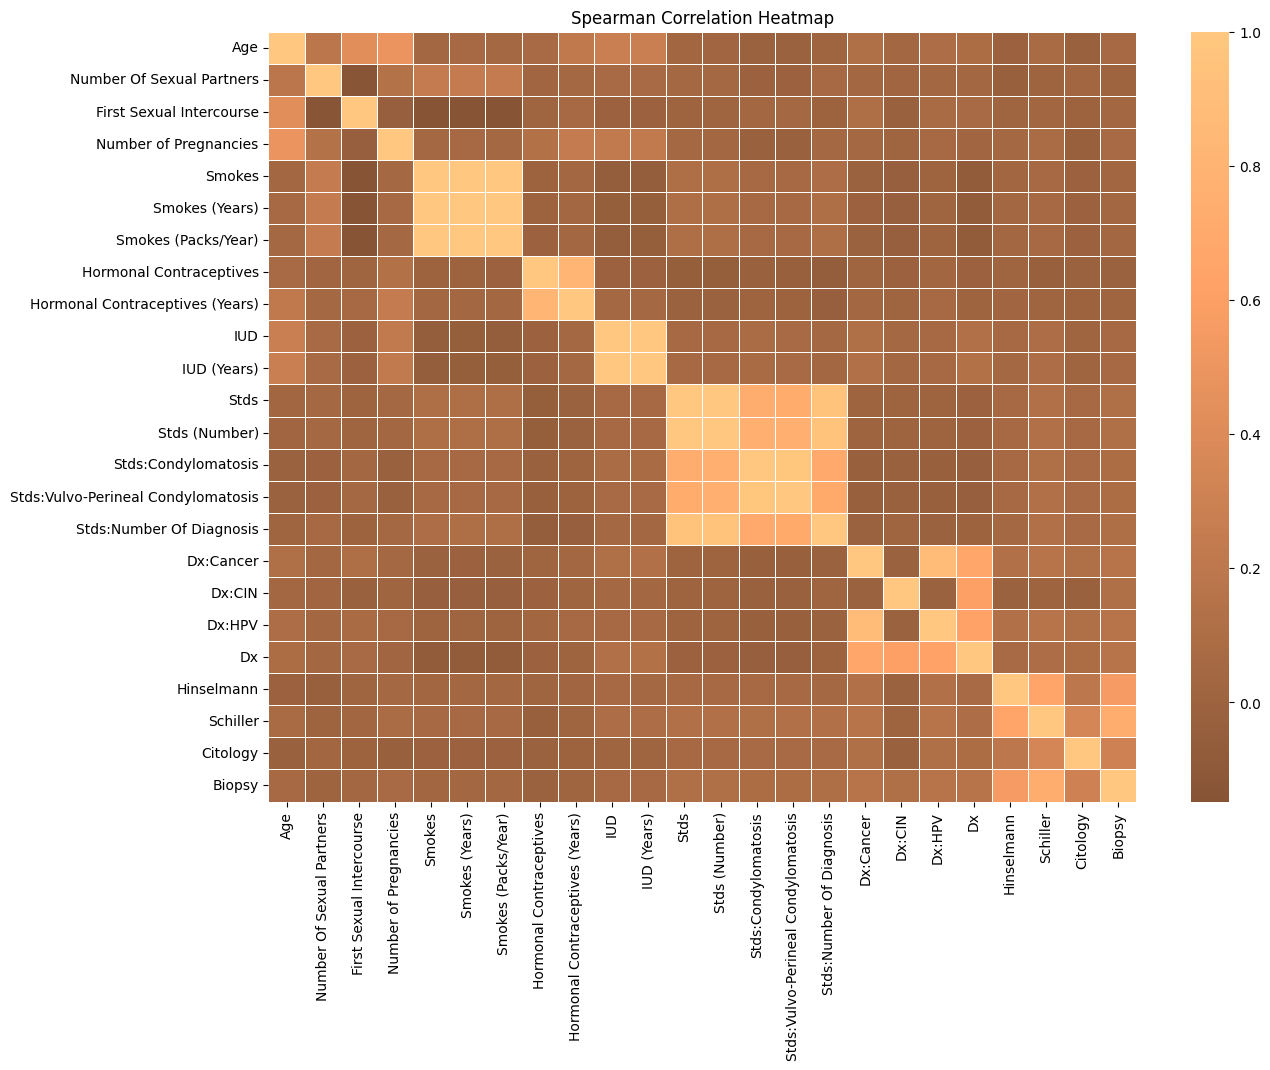

In [8]:
# Lets start with Spearman Correlation
# Compute Spearman correlation matrix
corr_matrix = main_df.corr(method="spearman")

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=False, cmap="copper", center=0, linewidths=0.5)
plt.title("Spearman Correlation Heatmap")
plt.show()

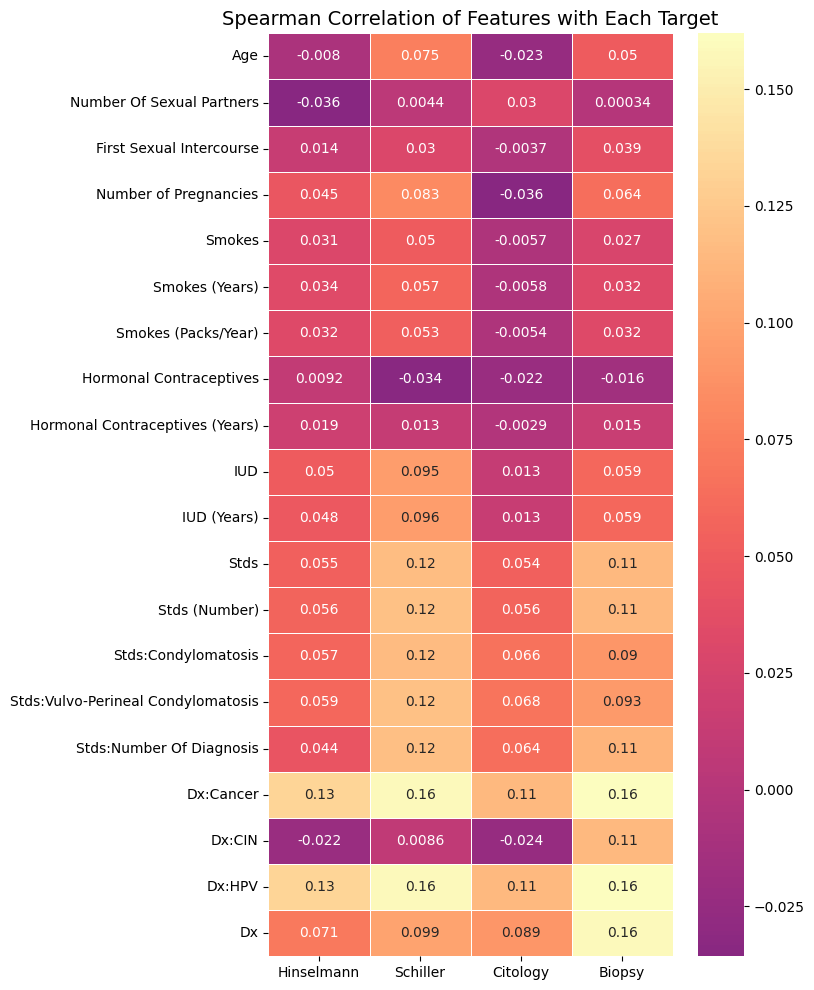

In [9]:
# Lets also check out how features correlate with the target variables
# Define target variables
target_vars = ['Hinselmann', 'Schiller', 'Citology', 'Biopsy']

# Compute Spearman correlation matrix
corr_matrix = main_df.corr(method="spearman")

# Extract only correlations of features with the target variables
target_corrs = corr_matrix[target_vars].drop(target_vars)

# Plot the heatmap
plt.figure(figsize=(8, 10))
sns.heatmap(target_corrs, annot=True, cmap="magma", center=0, linewidths=0.5)
plt.title("Spearman Correlation of Features with Each Target", fontsize=14)
plt.tight_layout()
plt.show()

####

#### Observations/General Trend:
#### Most features have very weak correlations with the targets (close to 0).
#### Nothing shows a strong monotonic relationship — correlations are generally < 0.1.
#### This seems to be typical in medical datasets where single features rarely dominate prediction — interaction and combinations often matter more.

#### None of these correalation values cross the typical "moderate" threshold (|ρ| > 0.3), so we'd likely rely more on:

#### a) Combinations of features

#### b) Non-linear models like trees or ensembles

#### c) Feature selection methods during modeling

####

In [10]:
# Lets test for multicollinearity of features (usinf VIF)
# Drop target variables to isolate predictors only
features_only = main_df.drop(columns=['Hinselmann', 'Schiller', 'Citology', 'Biopsy'])

# Scale data for VIF calculation (standardized inputs are best suited for VIF)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(features_only), columns=features_only.columns)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

# Display VIFs
vif_data.sort_values(by="VIF", ascending=False, inplace=True)
print(vif_data)

                               Feature        VIF
13                 Stds:Condylomatosis  49.275638
14  Stds:Vulvo-Perineal Condylomatosis  42.900193
12                       Stds (Number)  33.582318
11                                Stds  10.357926
15            Stds:Number Of Diagnosis   8.179179
16                           Dx:Cancer   6.842370
19                                  Dx   6.416449
18                              Dx:HPV   4.912615
5                       Smokes (Years)   3.621837
17                              Dx:CIN   3.457821
9                                  IUD   2.503962
10                         IUD (Years)   2.364346
4                               Smokes   2.279434
6                  Smokes (Packs/Year)   2.229411
0                                  Age   2.122842
3                Number of Pregnancies   1.565776
2             First Sexual Intercourse   1.402103
8      Hormonal Contraceptives (Years)   1.350521
7              Hormonal Contraceptives   1.220568


#### 

#### We see that there are features which show extreme VIF values. However the decision to drop/engineer them is not so simple, since they are all binary, and connected to each other (part of the STDS lists). I think that the best approach for now, is to save a list of the most severe cases, and then try different approaches during the modelling phase.
#### For example, we could drop these features if we want to try linear models, and also keep them and try tree-based models as well, comparing results.

In [11]:
high_vif_features = ["Stds:Condylomatosis", "Stds:Vulvo-Perineal Condylomatosis", "Stds (Number)", "Stds",
                     "Stds:Number Of Diagnosis", "Dx", "Dx:Cancer", "Dx:HPV"]


####

### 5) Relationships between Features and Targets
#### We will use KDE/boxplots/barplots/violin plots to compare feature values/distributions across the target subclasses.
#### For binary/categorical features, stacked barplots can be used.
#### The goal is to spot features with predictive power.

####

In [15]:
# Lets start with separating the features depending on their nature (binary/discrete/continuous)
# This will enable us to choose the right visualizations and tests for each group
# Split features based on number of unique values
binary_features = [col for col in main_df.columns if main_df[col].nunique() == 2 and col not in ['Hinselmann', 'Schiller', 'Citology', 'Biopsy']]
discrete_low_card = [col for col in main_df.columns if 3 <= main_df[col].nunique() <= 10]
discrete_high_card = [col for col in main_df.columns if main_df[col].nunique() > 10 and main_df[col].dtype in ['int64', 'float64']]

print("Binary features:", binary_features)
print("Discrete low-cardinality features:", discrete_low_card)
print("Discrete high-cardinality features:", discrete_high_card)


Binary features: ['Smokes', 'Hormonal Contraceptives', 'IUD', 'Stds', 'Stds:Condylomatosis', 'Stds:Vulvo-Perineal Condylomatosis', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx']
Discrete low-cardinality features: ['Stds (Number)', 'Stds:Number Of Diagnosis']
Discrete high-cardinality features: ['Age', 'Number Of Sexual Partners', 'First Sexual Intercourse', 'Number of Pregnancies', 'Smokes (Years)', 'Smokes (Packs/Year)', 'Hormonal Contraceptives (Years)', 'IUD (Years)']


####

#### Now we can start exploring relationships with the targets
### 5.1.1 - I will start with the "Biopsy" target and the continuous/discrete_high_card features:

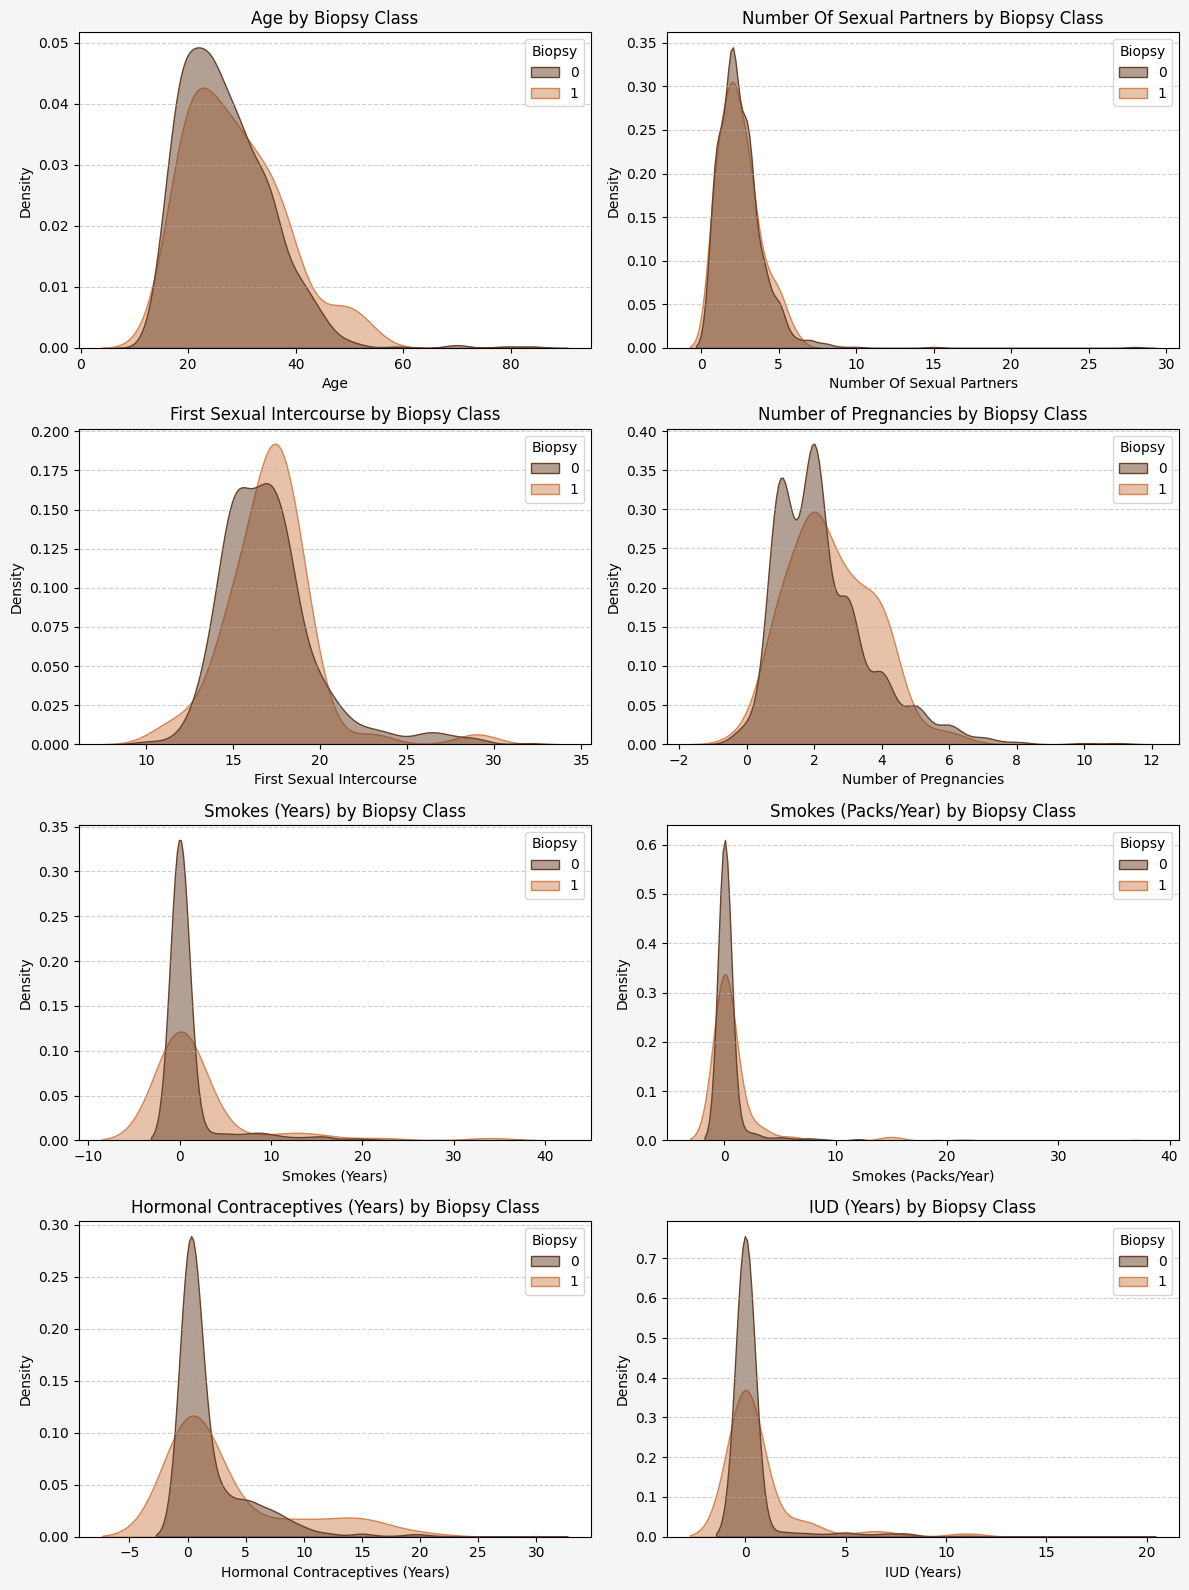

In [16]:
# Lets start with KDE plots to the appropriate feature group
# This are the discrete_high_card columns, the continuous/high-cardinality features
# Choose target to explore
target = "Biopsy"

# Plot KDEs 
n_cols = 2
n_rows = (len(discrete_high_card) + 1) // n_cols
plt.figure(figsize=(12, n_rows * 4), facecolor="whitesmoke")

for i, col in enumerate(discrete_high_card, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.kdeplot(data=main_df, x=col, hue=target, fill=True, common_norm=False, palette="copper", alpha=0.5)
    plt.title(f"{col} by {target} Class")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()



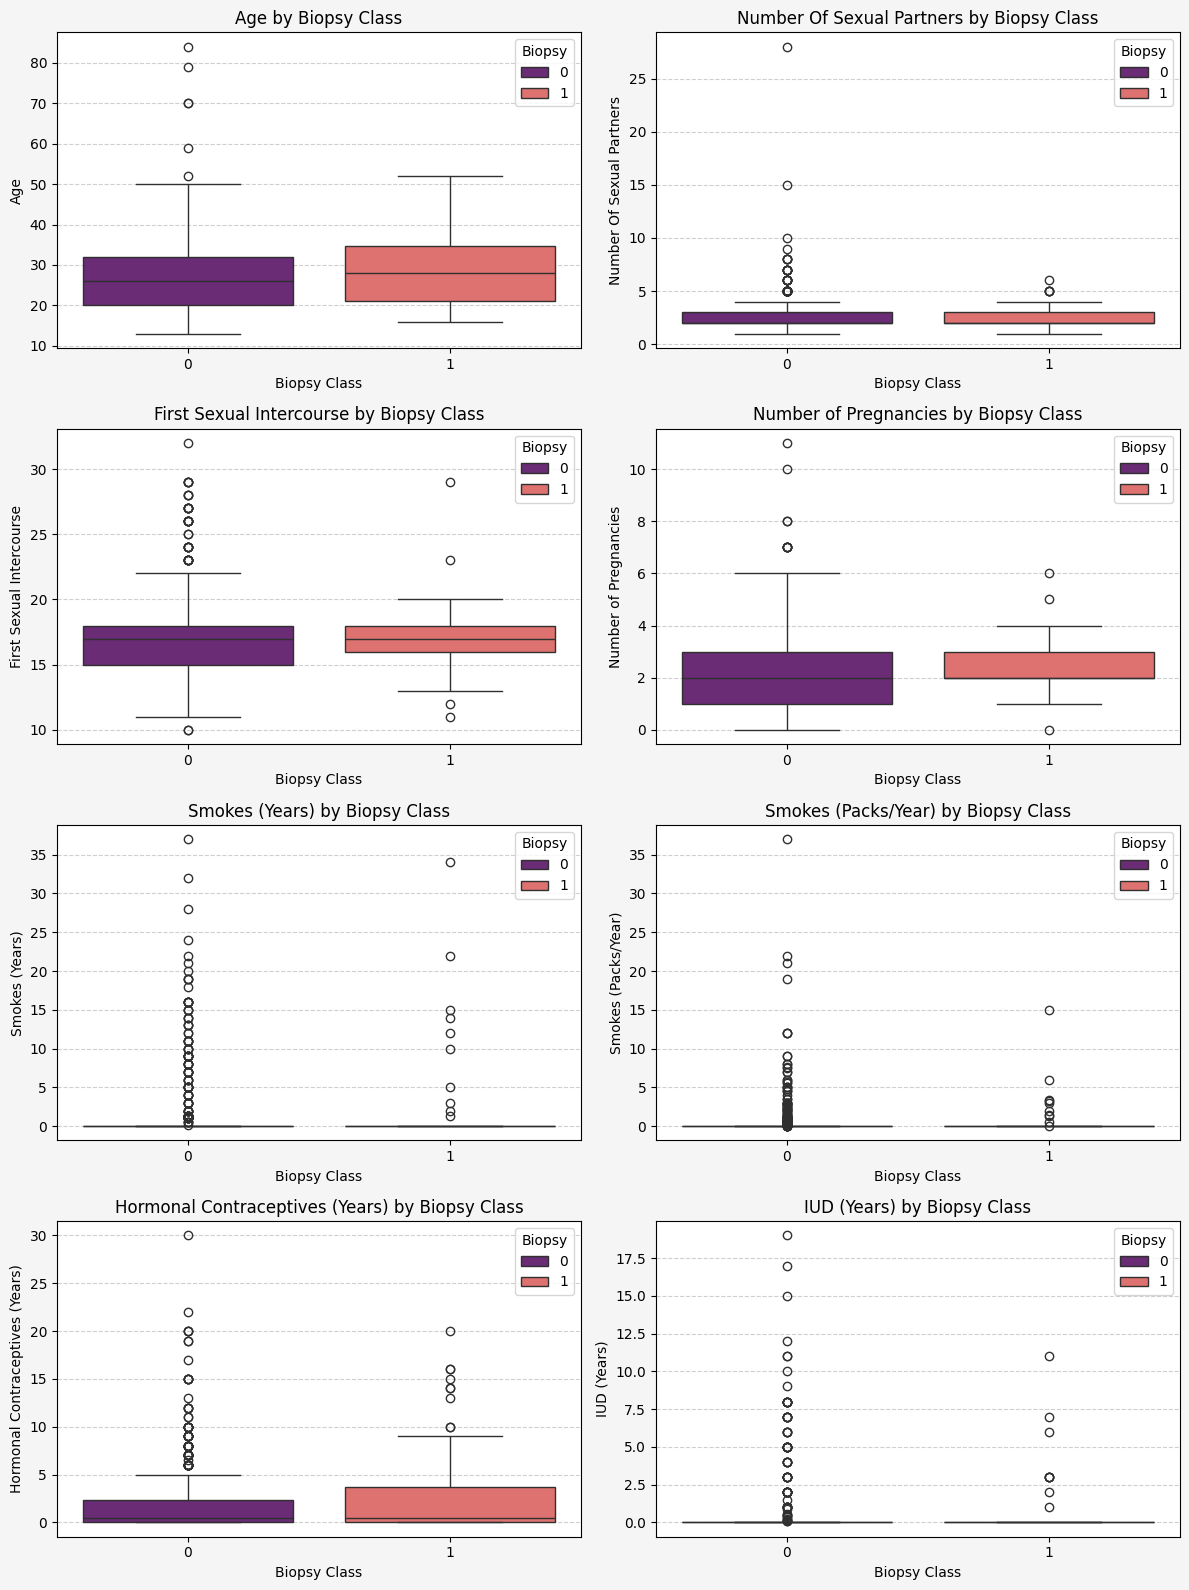

In [18]:
# Lets also generate some boxplots per target subclass, for these variables
# Plot boxplots
n_cols = 2
n_rows = (len(discrete_high_card) + 1) // n_cols
plt.figure(figsize=(12, n_rows * 4), facecolor="whitesmoke")

for i, col in enumerate(discrete_high_card, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=main_df, x=target, hue=target, y=col, palette="magma")
    plt.title(f"{col} by {target} Class")
    plt.xlabel("Biopsy Class")
    plt.ylabel(col)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


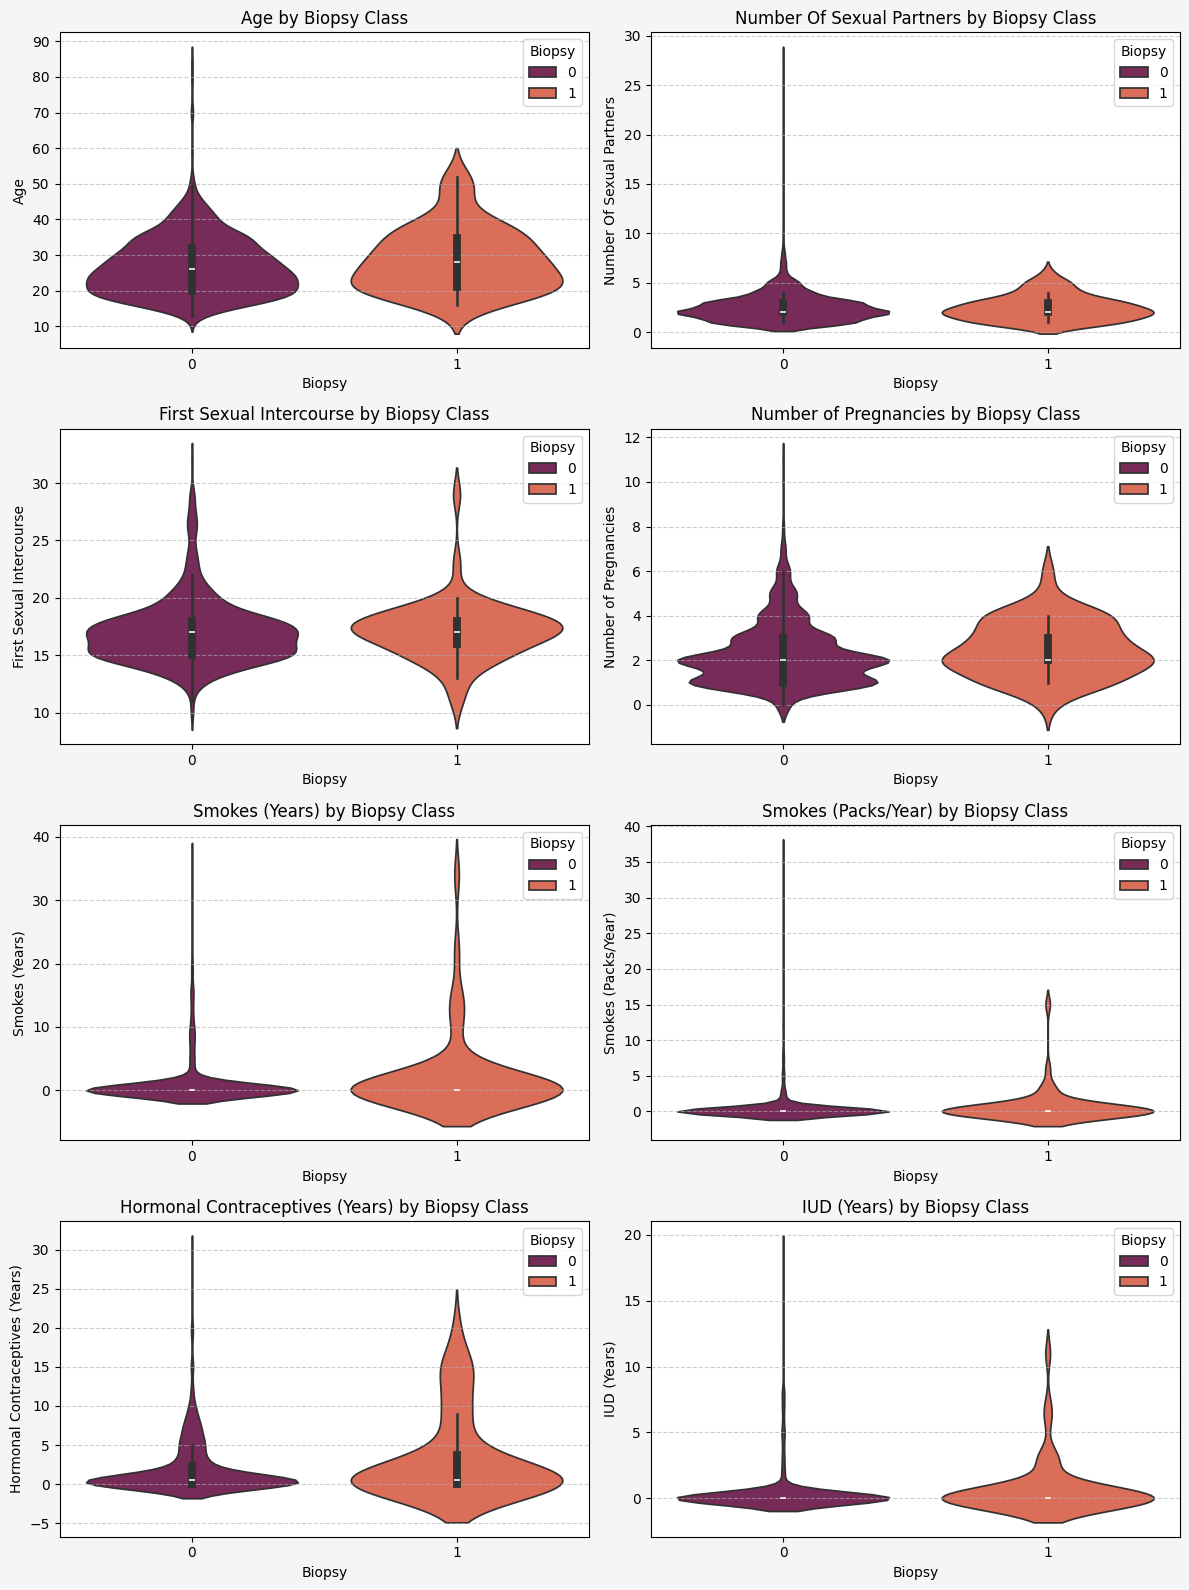

In [20]:
# Lets also try a few violin plots
n_cols = 2
n_rows = (len(discrete_high_card) + 1) // n_cols
plt.figure(figsize=(12, n_rows * 4), facecolor="whitesmoke")

for i, col in enumerate(discrete_high_card, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.violinplot(data=main_df, x=target, hue=target, y=col, palette="rocket", inner="box")
    plt.title(f"{col} by {target} Class")
    plt.xlabel("Biopsy")
    plt.ylabel(col)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [25]:
# We can see some features that show moderate differences in various aspects, across the Biopsy targets subclasses
# I will perform Mann-Whitney U Tests to see if these differences are statistically significant

# Manually define features to test — include all continuous + borderline ones
features_to_test = [
    'Age',
    'Number Of Sexual Partners',
    'First Sexual Intercourse',
    'Number of Pregnancies',
    'Smokes (Years)',
    'Smokes (Packs/Year)',
    'Hormonal Contraceptives (Years)',
    'IUD (Years)'
]

# Store results
mann_whitney_results = []

for feature in features_to_test:
    group_0 = main_df[main_df[target] == 0][feature]
    group_1 = main_df[main_df[target] == 1][feature]
    
    stat, p = stats.mannwhitneyu(group_0, group_1, alternative='two-sided')
    
    mann_whitney_results.append({
        'Feature': feature,
        'U Statistic': stat,
        'p-value': p,
        'Significant (p < 0.05)': 'Yes' if p < 0.05 else ('Borderline' if p < 0.10 else 'No')
    })

# Display as DataFrame
results_df = pd.DataFrame(mann_whitney_results).sort_values('p-value')
results_df.set_index('Feature', inplace=True)

# Show result
results_df


U Statistic   p-value Significant (p < 0.05)
Feature                                                                      
Number of Pregnancies                17910.0  0.063416             Borderline
IUD (Years)                          19451.0  0.090632             Borderline
Age                                  18508.5  0.151182                     No
First Sexual Intercourse             19061.0  0.261930                     No
Smokes (Years)                       19987.5  0.359835                     No
Smokes (Packs/Year)                  19997.0  0.364590                     No
Hormonal Contraceptives (Years)      20232.5  0.667722                     No
Number Of Sexual Partners            20936.0  0.992471                     No

#### It seems that there is no concrete evidence for statistically significant differences in these features
#### However p-values need not be completely binding, we can follow our visual examinations and clues from the plots, and choose features to use for modelling, even if the seem only weekly predictive for the Biopsy target.

###

### 5.1.2 - Lets continue with the Biopsy target and the low cardinality discrete value group:

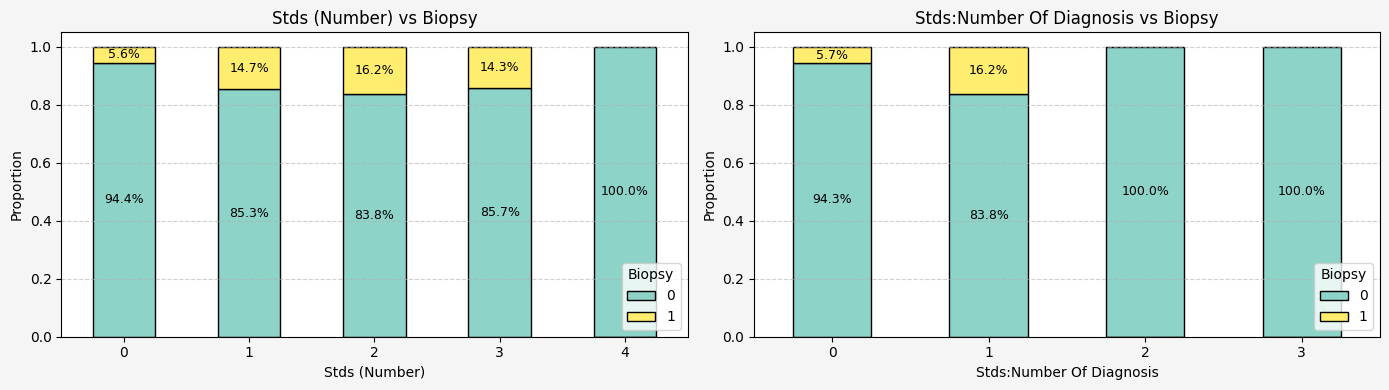

In [57]:
# Lets try stacked barplots to observe potential differences across the target subclasses

# Set up grid layout
n_cols = 2
n_rows = (len(discrete_low_card) + 1) // n_cols
plt.figure(figsize=(14, n_rows * 4), facecolor="whitesmoke")

# Generate stacked barplot for each feature
for i, feature in enumerate(discrete_low_card, 1):
    contingency = pd.crosstab(main_df[feature], main_df[target])
    proportions = contingency.div(contingency.sum(1), axis=0)

    ax = plt.subplot(n_rows, n_cols, i)
    bar_plot = proportions.plot(kind='bar', stacked=True, ax=ax, colormap="Set3", edgecolor='black')
    ax.set_title(f"{feature} vs {target}")
    ax.set_ylabel("Proportion")
    ax.set_xlabel(feature)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.legend(title=target, loc='lower right')
    plt.xticks(rotation=0)

    # Annotate percentages on each segment
    for container in bar_plot.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0.03:  # Avoid clutter for very small bars
                x = bar.get_x() + bar.get_width() / 2
                y = bar.get_y() + height / 2
                label = f"{height * 100:.1f}%"
                ax.text(x, y, label, ha='center', va='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()


In [34]:
# Test for statistical significance of the differences observed:
# (I will use a Chi-Squared Test for Independence)

# Store results
chi2_results = []

# Perform chi-squared test for each discrete low-card feature
for feature in discrete_low_card:
    contingency = pd.crosstab(main_df[feature], main_df[target])
    stat, p, dof, expected = stats.chi2_contingency(contingency)

    chi2_results.append({
        "Feature": feature,
        "Chi2 Stat": stat,
        "p-value": p,
        "Significant (p < 0.05)": "Yes" if p < 0.05 else "No"
    })

# Convert to DataFrame
chi2_df = pd.DataFrame(chi2_results).set_index("Feature").sort_values("p-value")
chi2_df


Chi2 Stat   p-value Significant (p < 0.05)
Feature                                                             
Stds:Number Of Diagnosis  11.545107  0.009116                    Yes
Stds (Number)             11.289967  0.023491                    Yes

#### Both Stds:Number Of Diagnosis and Stds (Number) show statistically significant differences in their value distribution across Biopsy classes:

#### Biopsy = 1 tends to cluster around higher STD counts

#### This confirms medical expectations — a history of multiple STDs is a known risk factor

#### These features are likely to be informative predictors and should be strongly considered during modeling (unless later removed due to multicollinearity, which we already bookmarked for testing!).

####

### 5.1.3 - Finally lets test the binary feature group with this target:

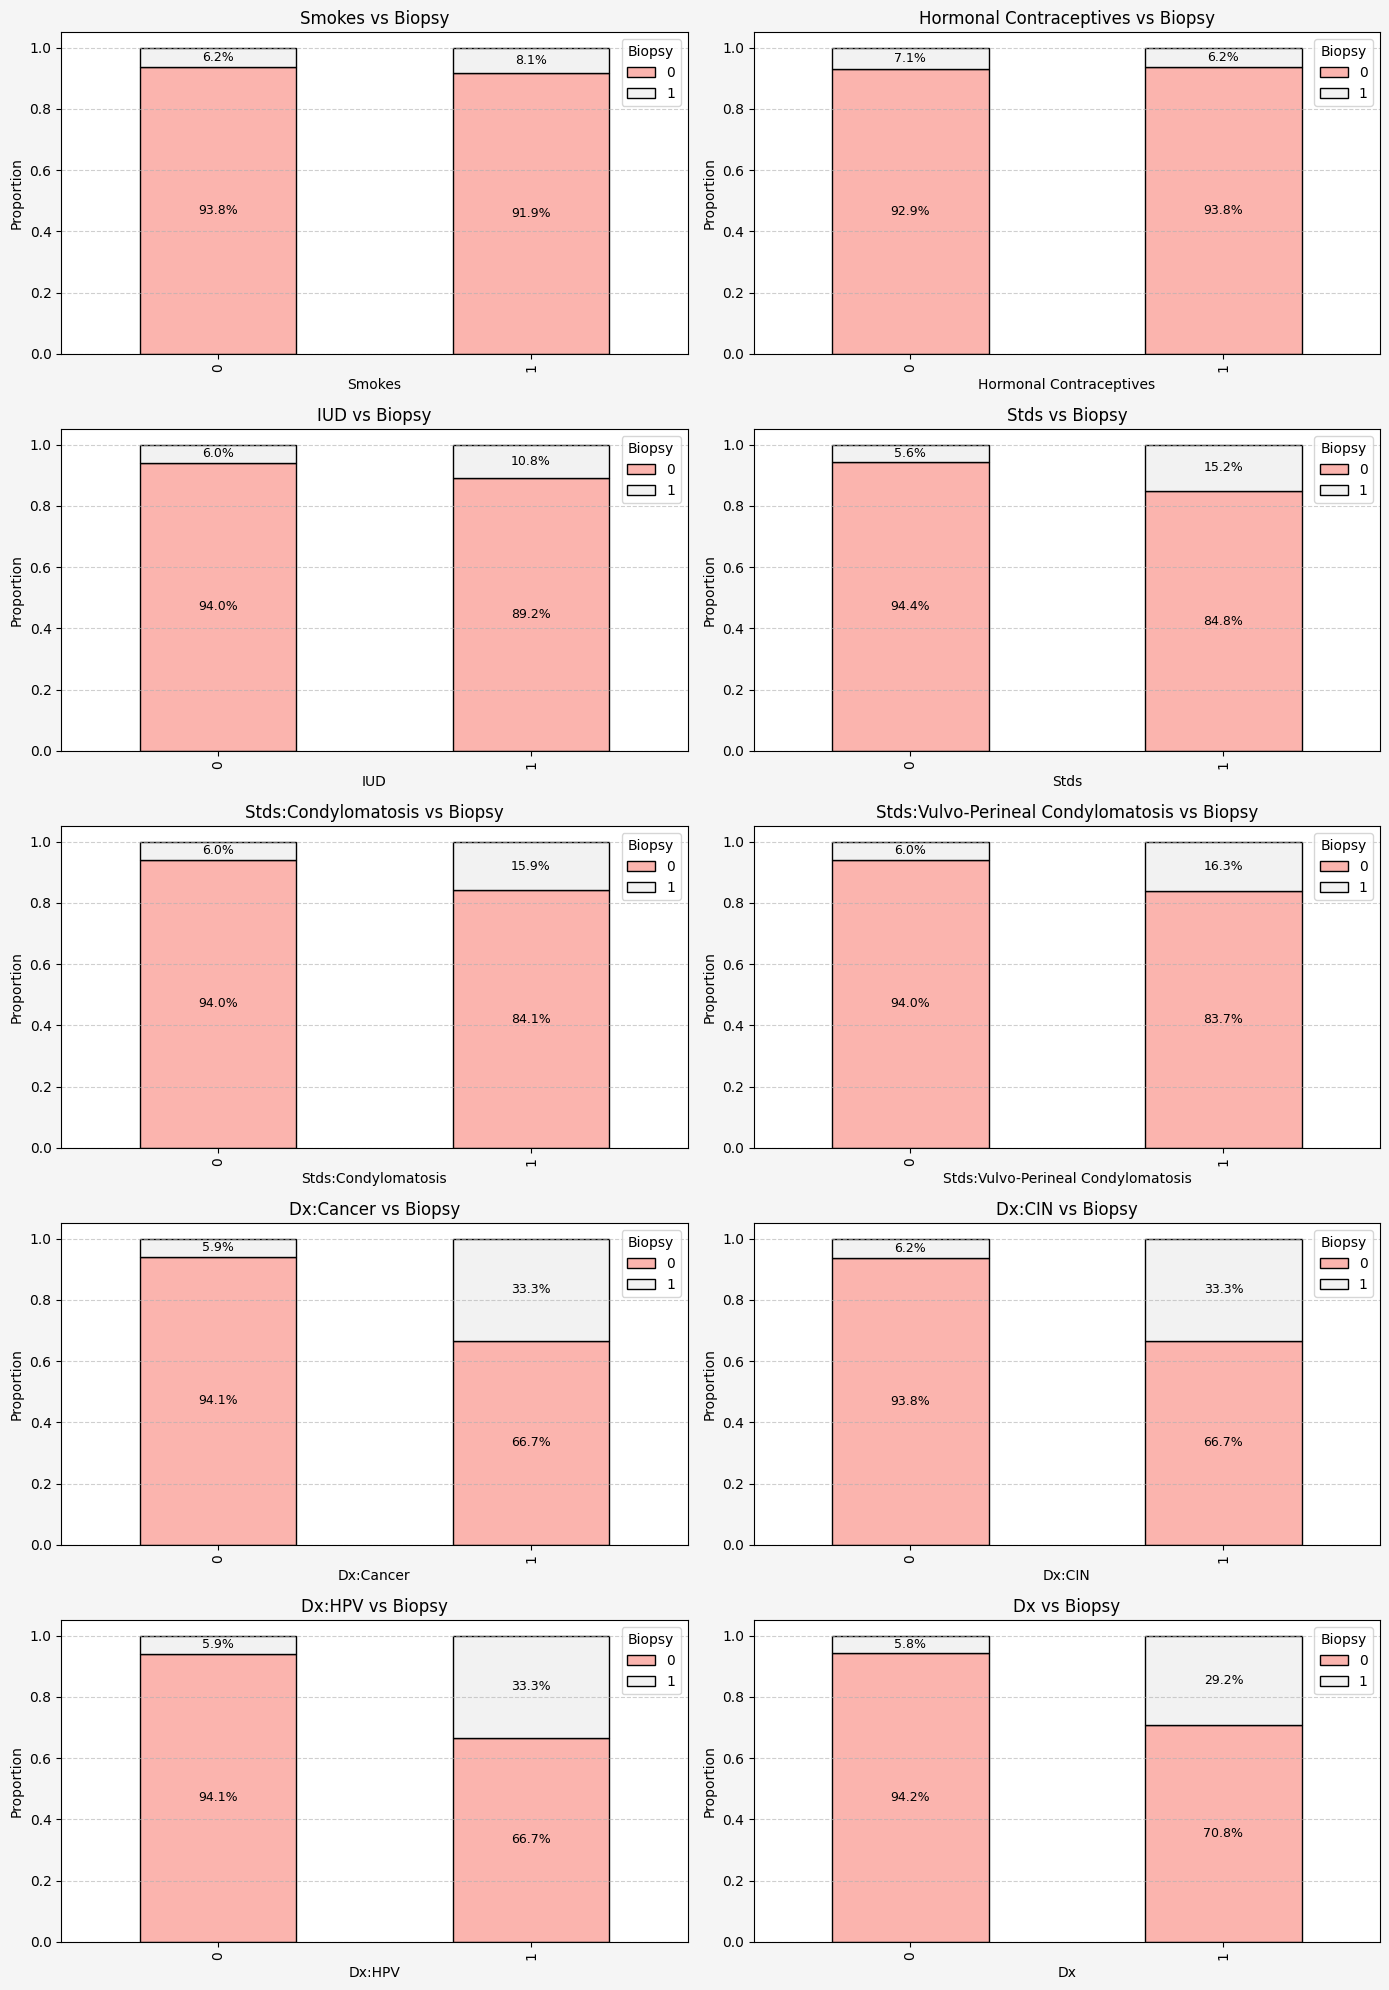

In [64]:
# Start with stacked barplots like above

# Set up subplot layout
n_cols = 2
n_rows = (len(binary_features) + 1) // n_cols
plt.figure(figsize=(14, n_rows * 4), facecolor="whitesmoke")

# Loop through each binary feature and plot stacked bars
for i, feature in enumerate(binary_features, 1):
    contingency = pd.crosstab(main_df[feature], main_df[target])
    proportions = contingency.div(contingency.sum(1), axis=0)

    ax = plt.subplot(n_rows, n_cols, i)
    bar_plot = proportions.plot(kind='bar', stacked=True, ax=ax, colormap="Pastel1", edgecolor='black')
    ax.set_title(f"{feature} vs {target}")
    ax.set_ylabel("Proportion")
    ax.set_xlabel(feature)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.legend(title=target, loc='upper right')
    plt.xticks(rotation=0)

    # Annotate bar segments with percentages
    for container in bar_plot.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0.03:
                x = bar.get_x() + bar.get_width() / 2
                y = bar.get_y() + height / 2
                label = f"{height * 100:.1f}%"
                ax.text(x, y, label, ha='center', va='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()


In [66]:
# There are observable differences for some of the features, across the target subclasses
# Once again, lets test for statistical significance
# Run Chi-squared tests and collect results
chi2_results_binary = []

for feature in binary_features:
    contingency = pd.crosstab(main_df[feature], main_df[target])
    stat, p, dof, expected = stats.chi2_contingency(contingency)

    chi2_results_binary.append({
        "Feature": feature,
        "Chi2 Stat": stat,
        "p-value": p,
        "Significant (p < 0.05)": "Yes" if p < 0.05 else "No"
    })

# Display results
chi2_bin_df = pd.DataFrame(chi2_results_binary).set_index("Feature").sort_values("p-value")
chi2_bin_df


Chi2 Stat   p-value Significant (p < 0.05)
Feature                                                                       
Dx:Cancer                           17.494781  0.000029                    Yes
Dx:HPV                              17.494781  0.000029                    Yes
Dx                                  17.204108  0.000034                    Yes
Stds                                 9.303769  0.002287                    Yes
Dx:CIN                               6.768380  0.009279                    Yes
Stds:Vulvo-Perineal Condylomatosis   5.527192  0.018723                    Yes
Stds:Condylomatosis                  5.220037  0.022328                    Yes
IUD                                  2.114966  0.145865                     No
Smokes                               0.351917  0.553030                     No
Hormonal Contraceptives              0.088606  0.765957                     No

####

#### 5.2.1 - Lets now move on to the next target, the Schiller variable, and repeat the whole pipeline:

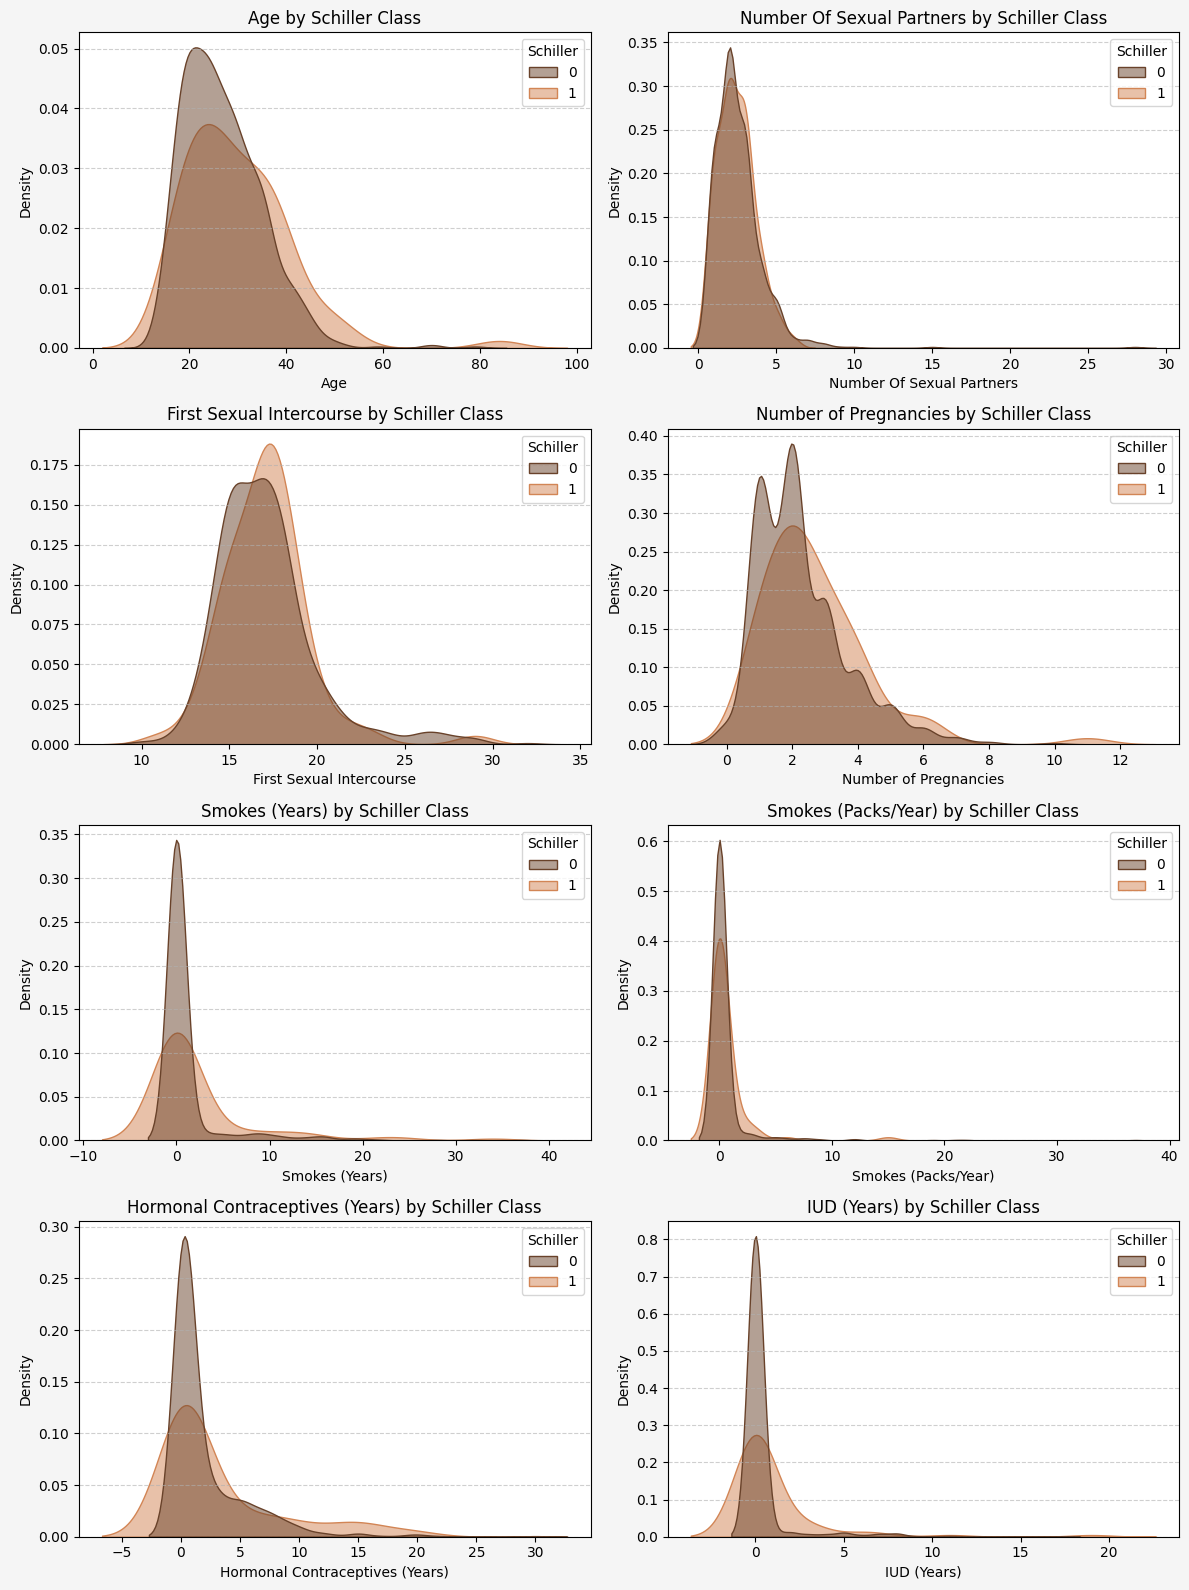

In [69]:
# Lets start with KDE plots again, following the same approach and order 
# This will be the discrete_high_card columns, the continuous/high-cardinality features once again, to start
# Choose target to explore
target = "Schiller"

# Plot KDEs 
n_cols = 2
n_rows = (len(discrete_high_card) + 1) // n_cols
plt.figure(figsize=(12, n_rows * 4), facecolor="whitesmoke")

for i, col in enumerate(discrete_high_card, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.kdeplot(data=main_df, x=col, hue=target, fill=True, common_norm=False, palette="copper", alpha=0.5)
    plt.title(f"{col} by {target} Class")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


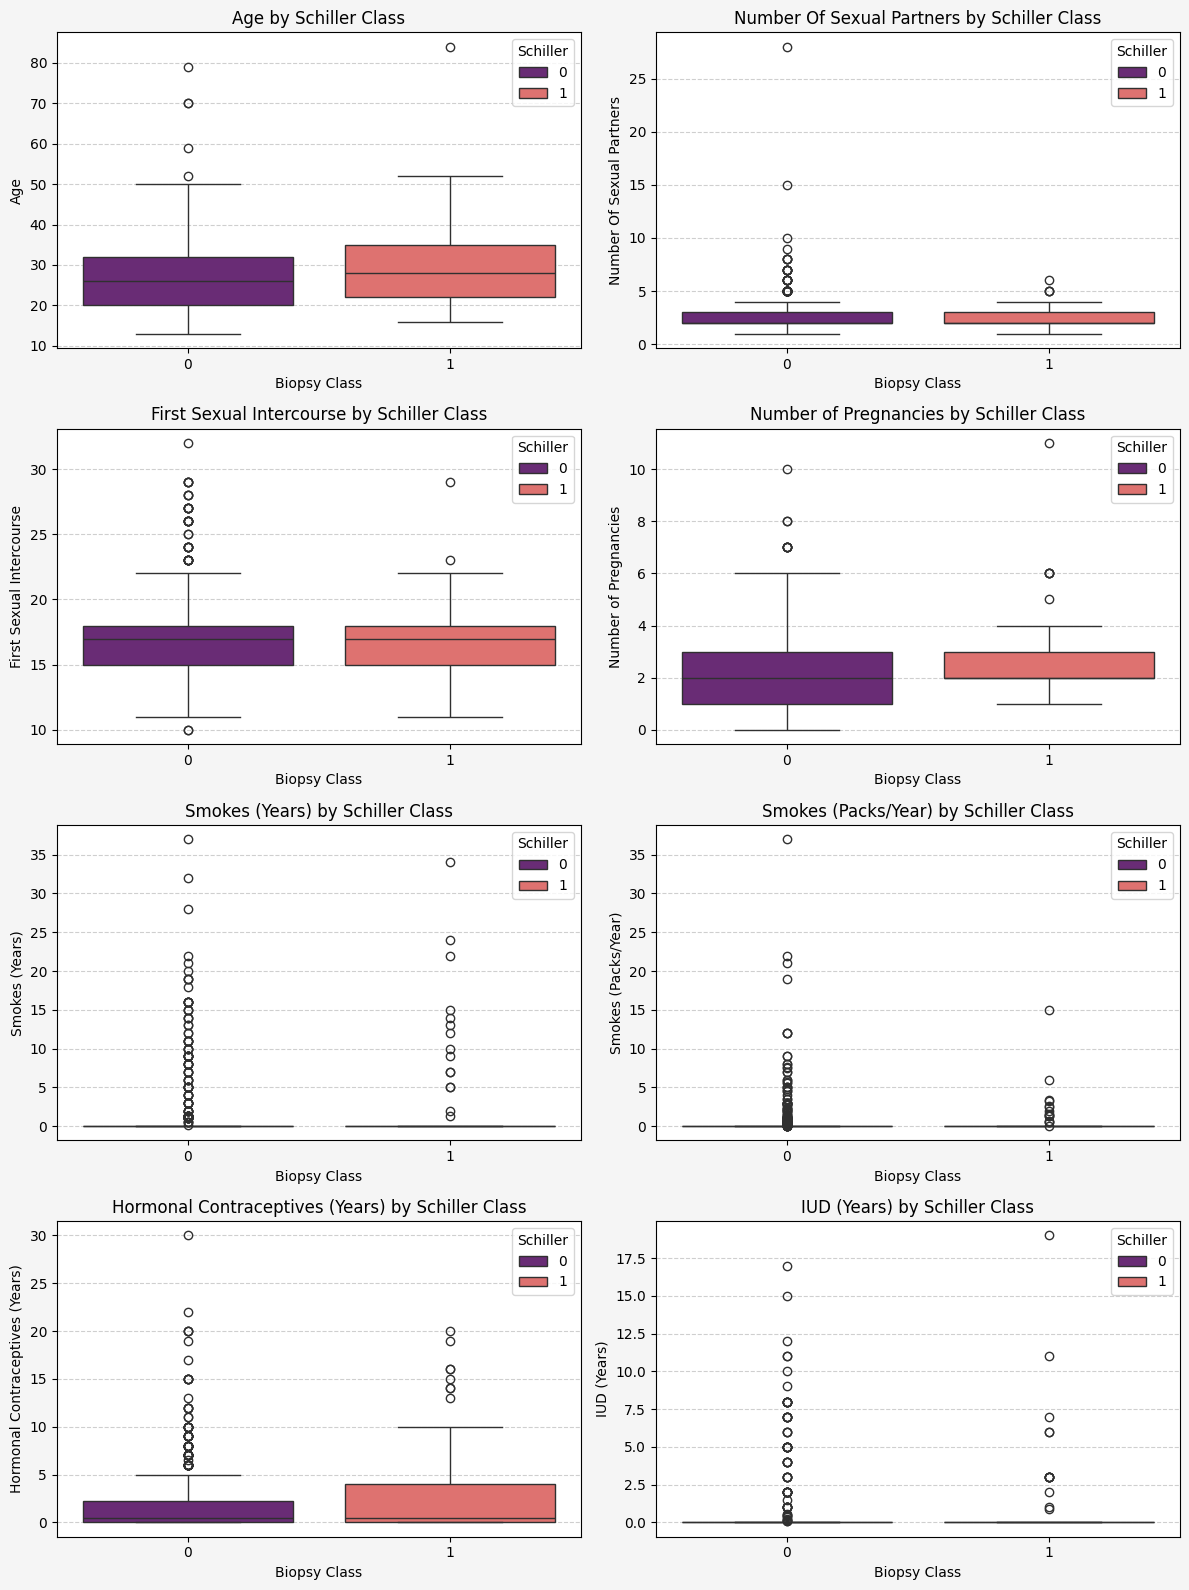

In [70]:
# Lets also generate some boxplots per target subclass, for these variables
# Plot boxplots
n_cols = 2
n_rows = (len(discrete_high_card) + 1) // n_cols
plt.figure(figsize=(12, n_rows * 4), facecolor="whitesmoke")

for i, col in enumerate(discrete_high_card, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=main_df, x=target, hue=target, y=col, palette="magma")
    plt.title(f"{col} by {target} Class")
    plt.xlabel("Biopsy Class")
    plt.ylabel(col)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


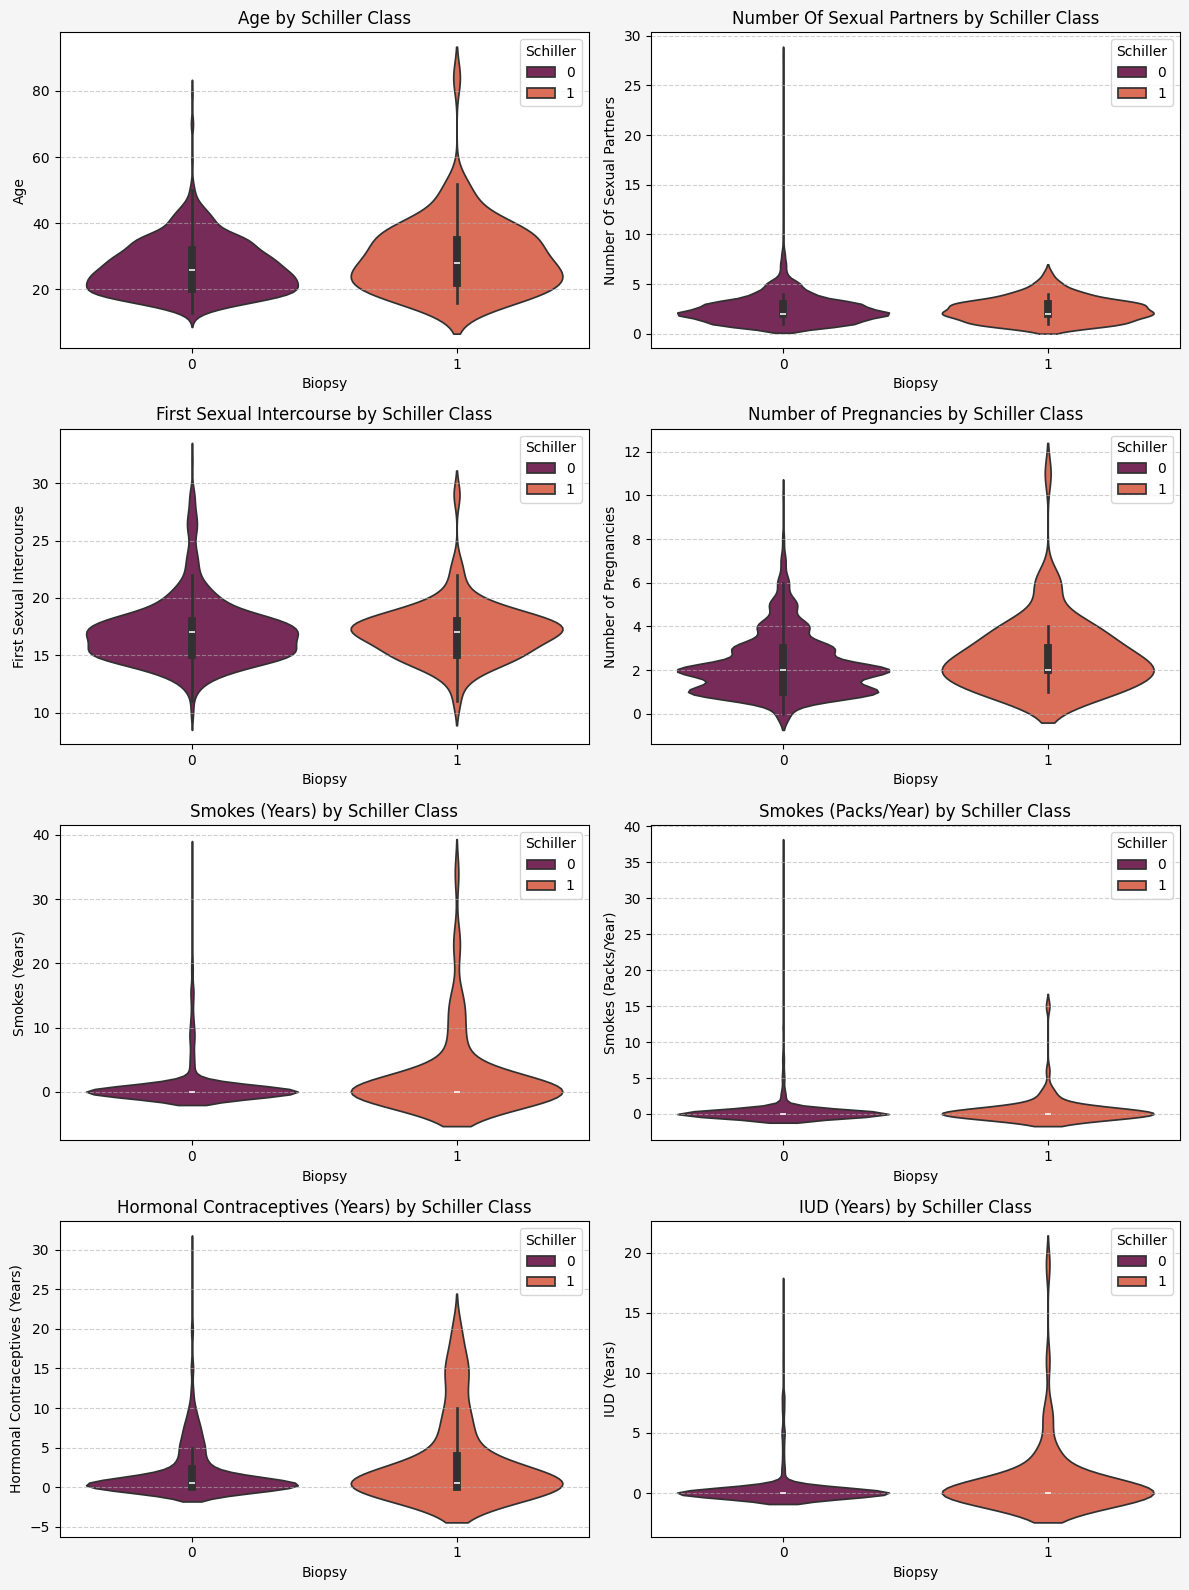

In [71]:
# And on to the violin plots
n_cols = 2
n_rows = (len(discrete_high_card) + 1) // n_cols
plt.figure(figsize=(12, n_rows * 4), facecolor="whitesmoke")

for i, col in enumerate(discrete_high_card, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.violinplot(data=main_df, x=target, hue=target, y=col, palette="rocket", inner="box")
    plt.title(f"{col} by {target} Class")
    plt.xlabel("Biopsy")
    plt.ylabel(col)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [ ]:
# The visual results so far are extremely similar to the results we got for the Biopsy target, from these features
# I will perform Mann-Whitney U Tests once again, to locate any potential statistical significance

# Manually define features to test — include all continuous + borderline ones
features_to_test = [
    'Age',
    'Number Of Sexual Partners',
    'First Sexual Intercourse',
    'Number of Pregnancies',
    'Smokes (Years)',
    'Smokes (Packs/Year)',
    'Hormonal Contraceptives (Years)',
    'IUD (Years)'
]

# Store results
mann_whitney_results = []

for feature in features_to_test:
    group_0 = main_df[main_df[target] == 0][feature]
    group_1 = main_df[main_df[target] == 1][feature]
    
    stat, p = stats.mannwhitneyu(group_0, group_1, alternative='two-sided')
    
    mann_whitney_results.append({
        'Feature': feature,
        'U Statistic': stat,
        'p-value': p,
        'Significant (p < 0.05)': 'Yes' if p < 0.05 else ('Borderline' if p < 0.10 else 'No')
    })

# Display as DataFrame
results_df = pd.DataFrame(mann_whitney_results).sort_values('p-value')
results_df.set_index('Feature', inplace=True)

# Show result
results_df


#### So this time, even though visual examination shows similar results to the Biopsy target, here we see that there are a few statistically significant differences for this feature group, across the Schiller target subclasses.

####

### 5.2.2 - Lets continue with the Schiller target and the low cardinality discrete value group:

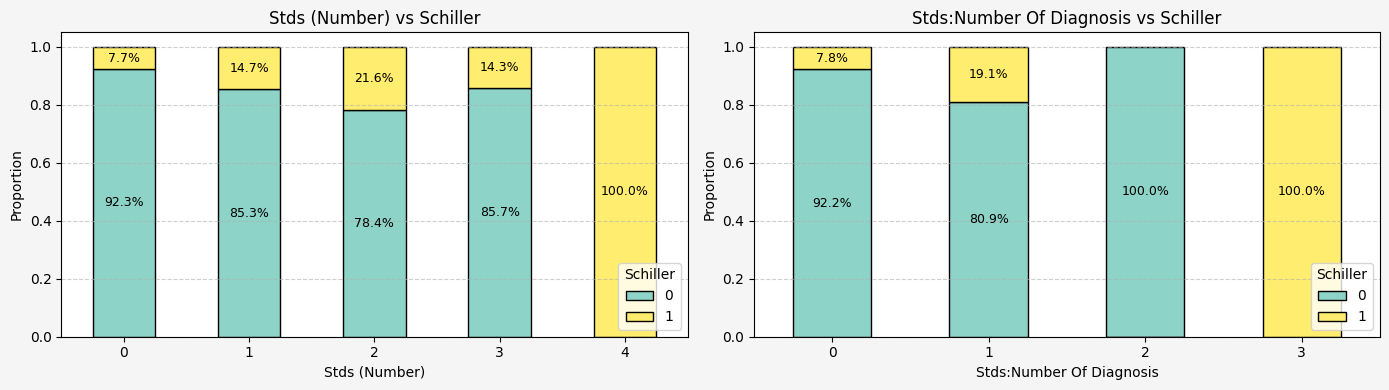

In [73]:
# Lets try stacked barplots again, to observe potential differences across the target subclasses

# Set up grid layout
n_cols = 2
n_rows = (len(discrete_low_card) + 1) // n_cols
plt.figure(figsize=(14, n_rows * 4), facecolor="whitesmoke")

# Generate stacked barplot for each feature
for i, feature in enumerate(discrete_low_card, 1):
    contingency = pd.crosstab(main_df[feature], main_df[target])
    proportions = contingency.div(contingency.sum(1), axis=0)

    ax = plt.subplot(n_rows, n_cols, i)
    bar_plot = proportions.plot(kind='bar', stacked=True, ax=ax, colormap="Set3", edgecolor='black')
    ax.set_title(f"{feature} vs {target}")
    ax.set_ylabel("Proportion")
    ax.set_xlabel(feature)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.legend(title=target, loc='lower right')
    plt.xticks(rotation=0)

    # Annotate percentages on each segment
    for container in bar_plot.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0.03:  # Avoid clutter for very small bars
                x = bar.get_x() + bar.get_width() / 2
                y = bar.get_y() + height / 2
                label = f"{height * 100:.1f}%"
                ax.text(x, y, label, ha='center', va='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()

In [74]:
# Interesting differences can be observed
# Test for statistical significance of the differences observed:
# (I will use a Chi-Squared Test for Independence)

# Store results
chi2_results = []

# Perform chi-squared test for each discrete low-card feature
for feature in discrete_low_card:
    contingency = pd.crosstab(main_df[feature], main_df[target])
    stat, p, dof, expected = stats.chi2_contingency(contingency)

    chi2_results.append({
        "Feature": feature,
        "Chi2 Stat": stat,
        "p-value": p,
        "Significant (p < 0.05)": "Yes" if p < 0.05 else "No"
    })

# Convert to DataFrame
chi2_df = pd.DataFrame(chi2_results).set_index("Feature").sort_values("p-value")
chi2_df


Chi2 Stat   p-value Significant (p < 0.05)
Feature                                                             
Stds:Number Of Diagnosis  20.583226  0.000128                    Yes
Stds (Number)             20.778323  0.000350                    Yes

####

### 5.2.3 - Finally lets test the binary feature group with this target:

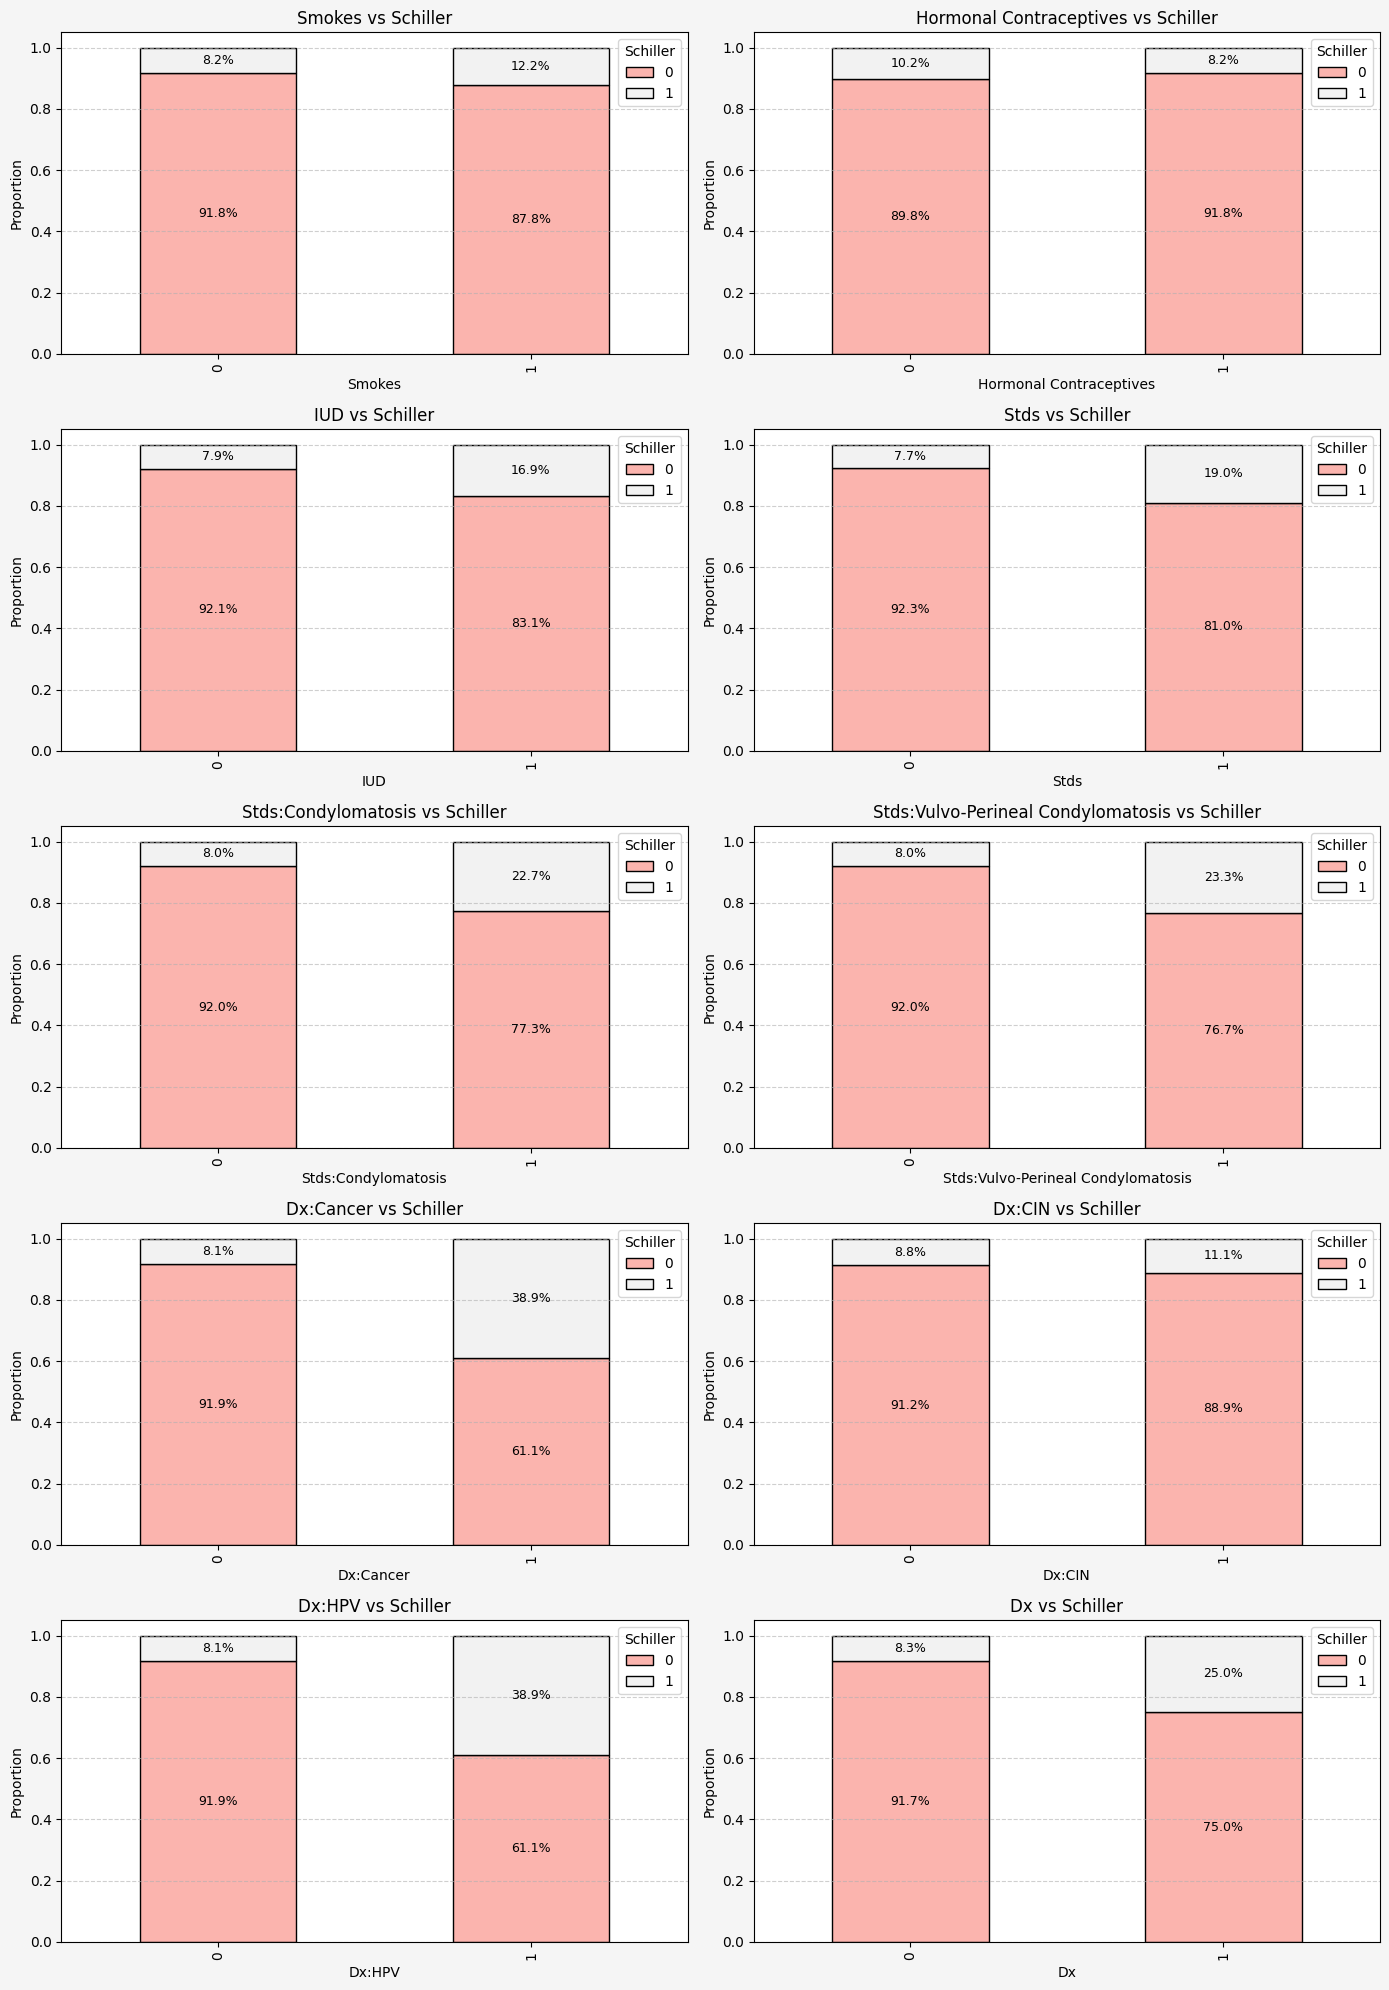

In [75]:
# Stacked barplots:
# Set up subplot layout
n_cols = 2
n_rows = (len(binary_features) + 1) // n_cols
plt.figure(figsize=(14, n_rows * 4), facecolor="whitesmoke")

# Loop through each binary feature and plot stacked bars
for i, feature in enumerate(binary_features, 1):
    contingency = pd.crosstab(main_df[feature], main_df[target])
    proportions = contingency.div(contingency.sum(1), axis=0)

    ax = plt.subplot(n_rows, n_cols, i)
    bar_plot = proportions.plot(kind='bar', stacked=True, ax=ax, colormap="Pastel1", edgecolor='black')
    ax.set_title(f"{feature} vs {target}")
    ax.set_ylabel("Proportion")
    ax.set_xlabel(feature)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.legend(title=target, loc='upper right')
    plt.xticks(rotation=0)

    # Annotate bar segments with percentages
    for container in bar_plot.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0.03:
                x = bar.get_x() + bar.get_width() / 2
                y = bar.get_y() + height / 2
                label = f"{height * 100:.1f}%"
                ax.text(x, y, label, ha='center', va='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()

In [76]:
# Again, we can spot observable differences for some of the features, across the target subclasses
# Once again, lets test for statistical significance
# Run Chi-squared tests and collect results
chi2_results_binary = []

for feature in binary_features:
    contingency = pd.crosstab(main_df[feature], main_df[target])
    stat, p, dof, expected = stats.chi2_contingency(contingency)

    chi2_results_binary.append({
        "Feature": feature,
        "Chi2 Stat": stat,
        "p-value": p,
        "Significant (p < 0.05)": "Yes" if p < 0.05 else "No"
    })

# Display results
chi2_bin_df = pd.DataFrame(chi2_results_binary).set_index("Feature").sort_values("p-value")
chi2_bin_df

Chi2 Stat   p-value Significant (p < 0.05)
Feature                                                                       
Dx:Cancer                           17.114492  0.000035                    Yes
Dx:HPV                              17.114492  0.000035                    Yes
Stds:Vulvo-Perineal Condylomatosis   9.997045  0.001568                    Yes
Stds                                 9.946042  0.001612                    Yes
Stds:Condylomatosis                  9.483654  0.002073                    Yes
IUD                                  6.415053  0.011316                    Yes
Dx                                   6.144019  0.013186                    Yes
Smokes                               1.613027  0.204067                     No
Hormonal Contraceptives              0.706317  0.400669                     No
Dx:CIN                               0.000000  1.000000                     No

#### Results are similar to the previous target, but with some differences.
#### Lets repeat the pipeline for the next two targets and then we can examine the overall results and proceed to feature selection/dimensionality reduction before the modelling phase.

####

#### 5.3.1 - Next target: the Citology variable

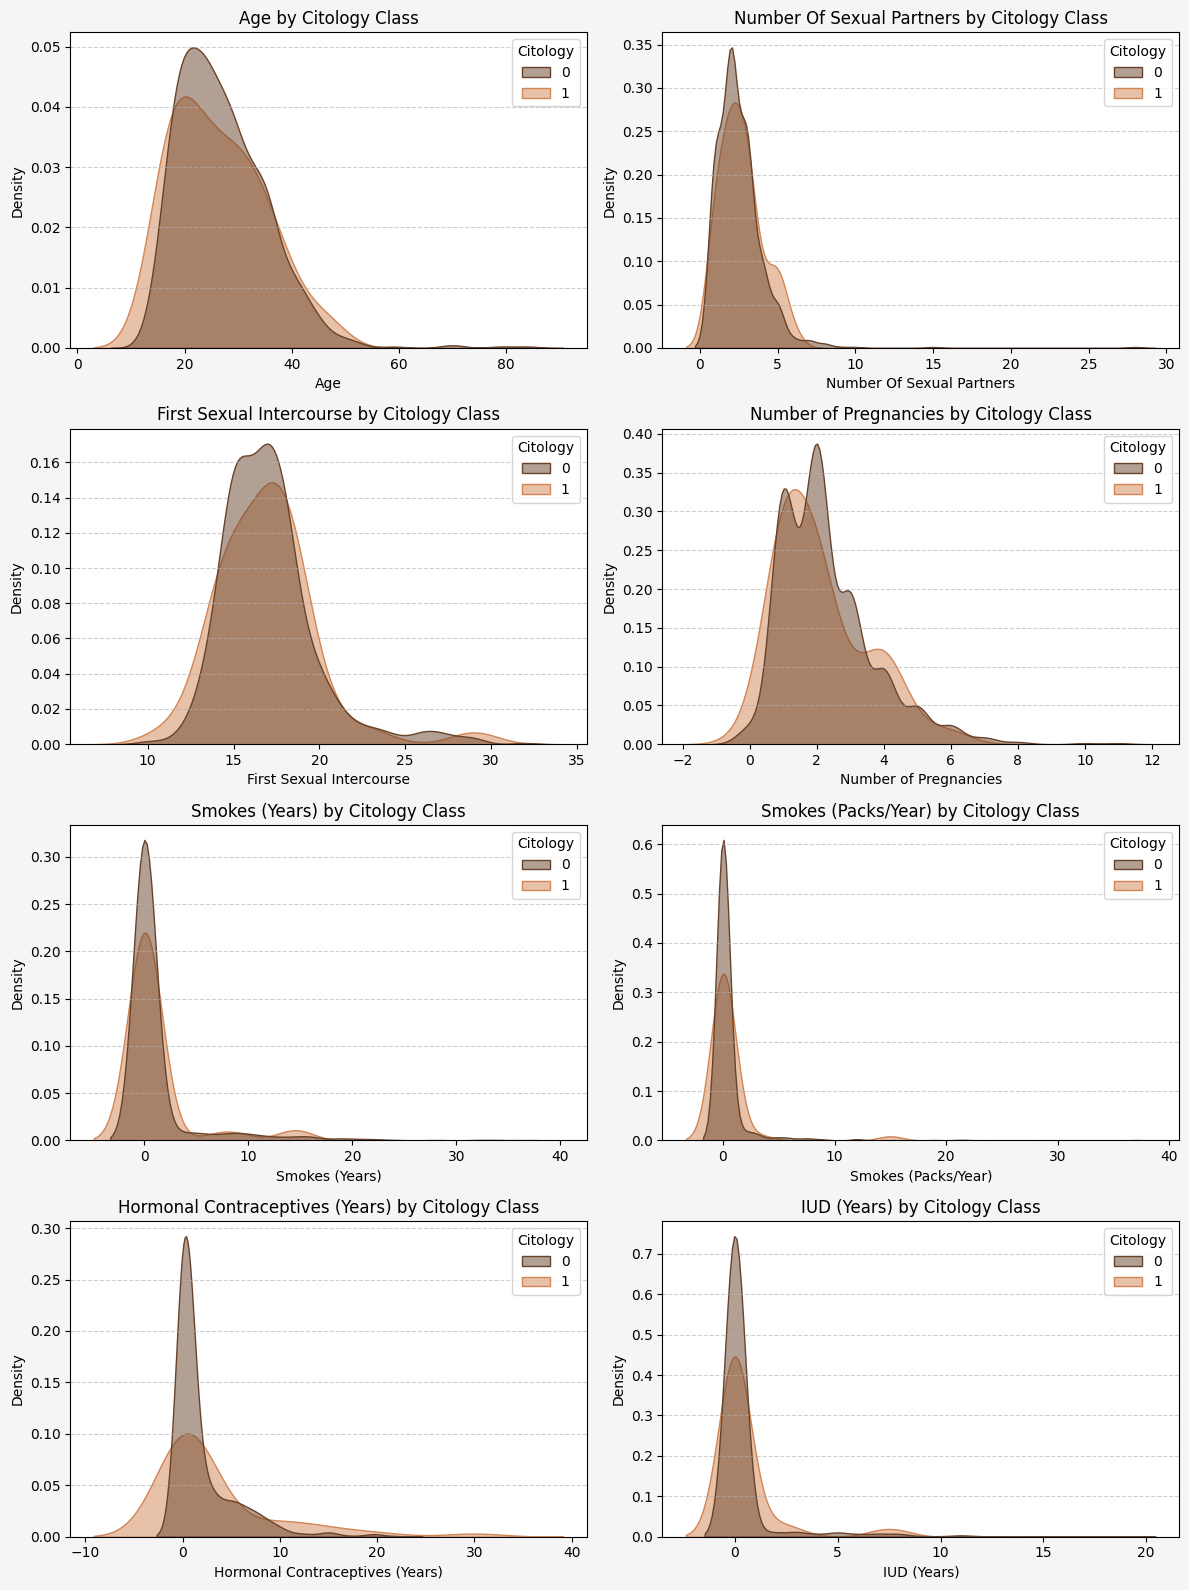

In [77]:
# Lets start with KDE plots again, following the same approach and order 
# This will be the discrete_high_card columns, the continuous/high-cardinality features once again, to start
# Choose target to explore
target = "Citology"

# Plot KDEs 
n_cols = 2
n_rows = (len(discrete_high_card) + 1) // n_cols
plt.figure(figsize=(12, n_rows * 4), facecolor="whitesmoke")

for i, col in enumerate(discrete_high_card, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.kdeplot(data=main_df, x=col, hue=target, fill=True, common_norm=False, palette="copper", alpha=0.5)
    plt.title(f"{col} by {target} Class")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

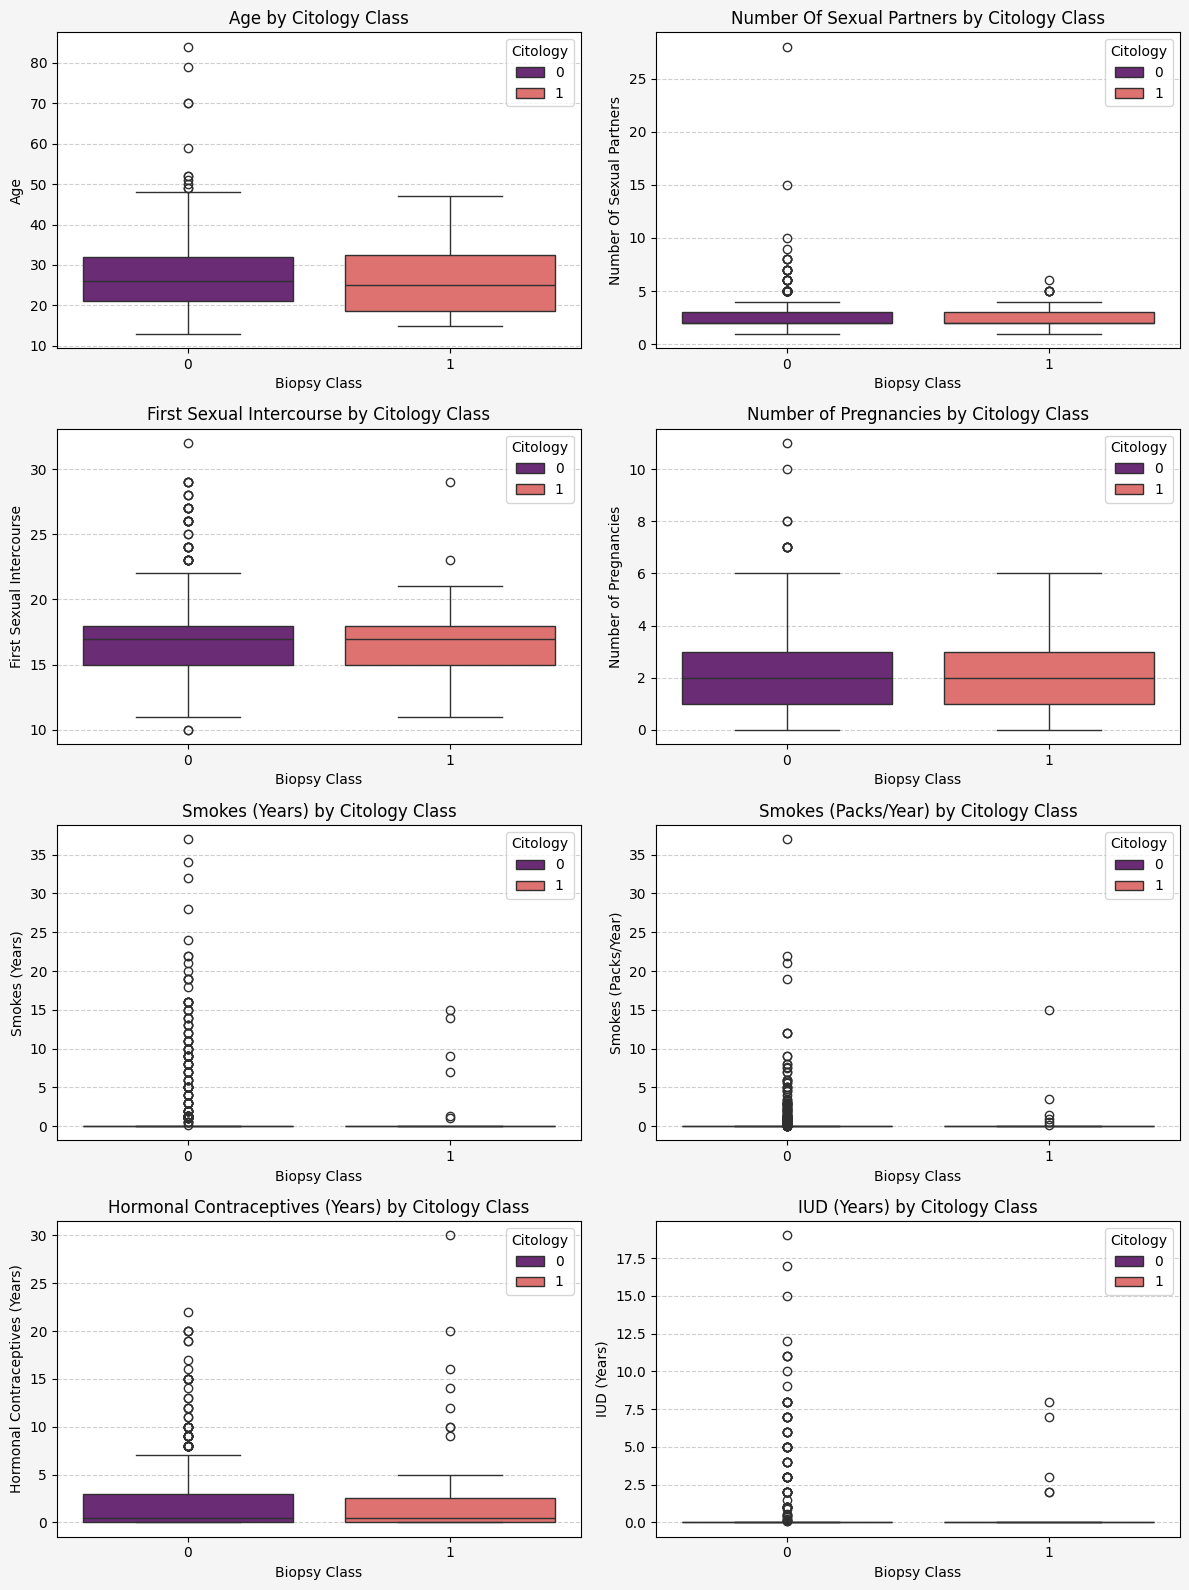

In [78]:
# Lets also generate some boxplots per target subclass, for these variables
# Plot boxplots
n_cols = 2
n_rows = (len(discrete_high_card) + 1) // n_cols
plt.figure(figsize=(12, n_rows * 4), facecolor="whitesmoke")

for i, col in enumerate(discrete_high_card, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=main_df, x=target, hue=target, y=col, palette="magma")
    plt.title(f"{col} by {target} Class")
    plt.xlabel("Biopsy Class")
    plt.ylabel(col)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


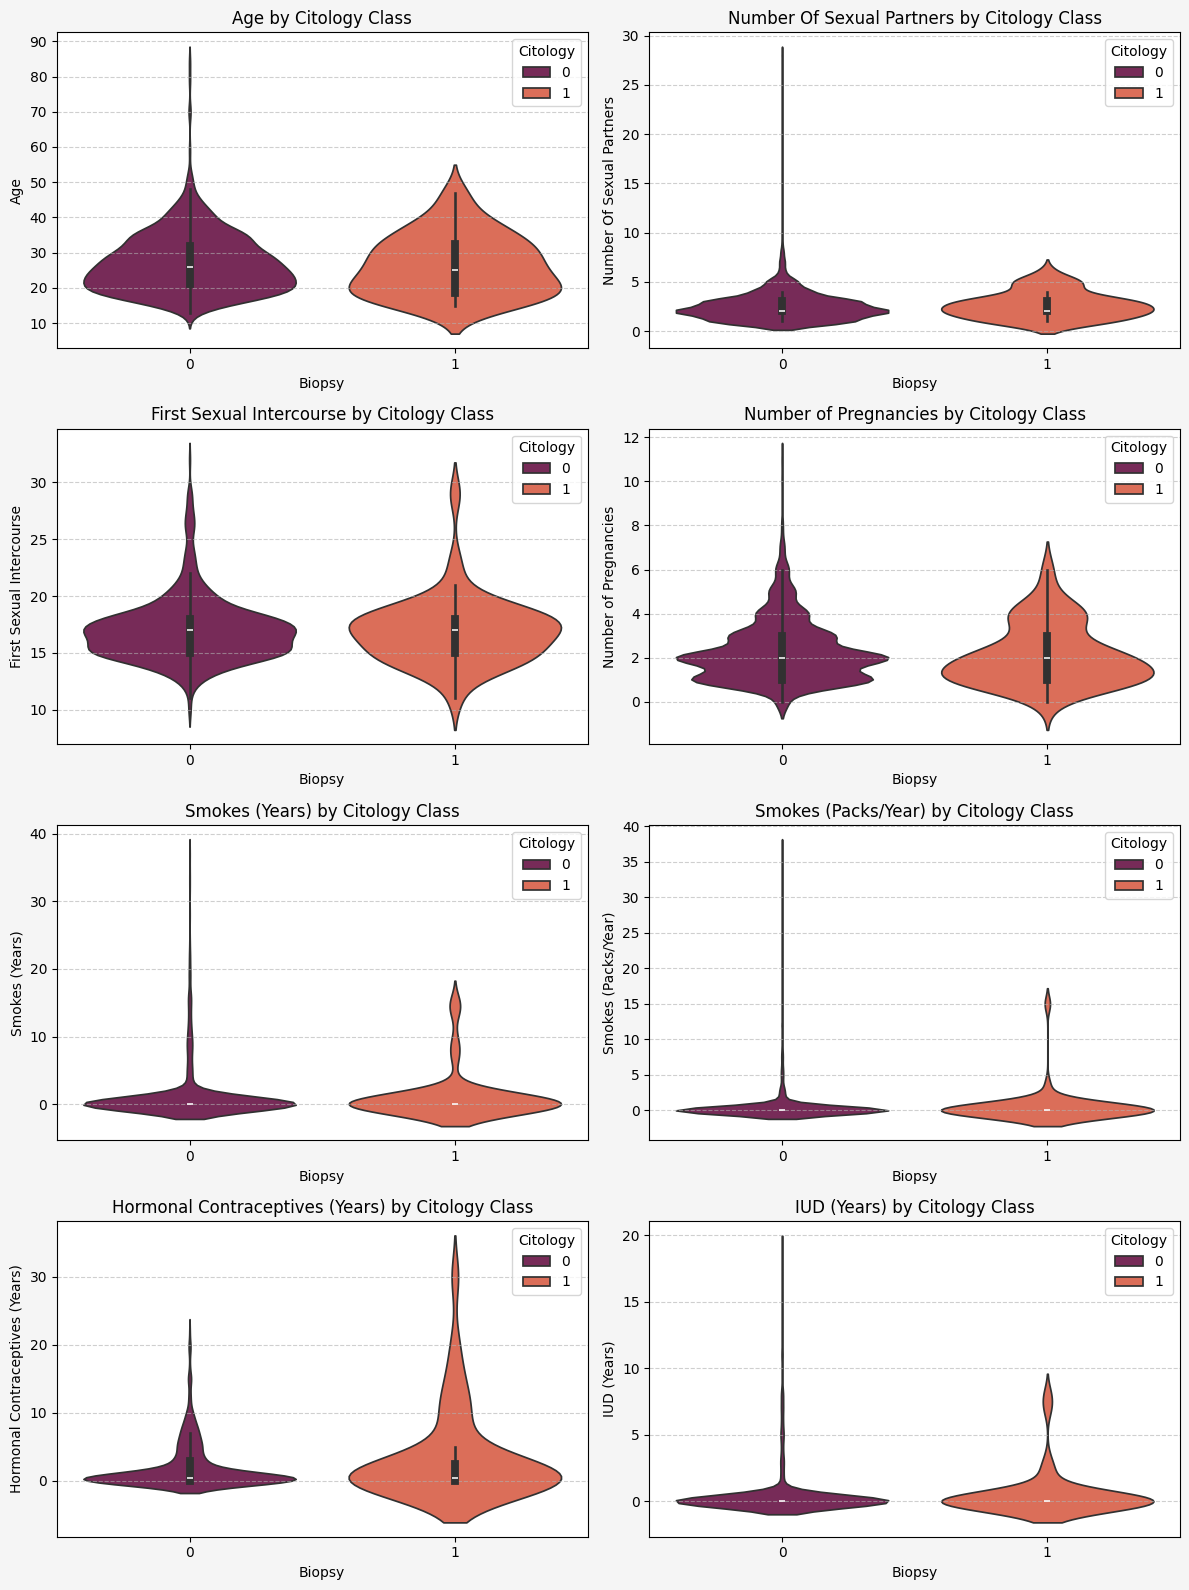

In [79]:
# And on to the violin plots
n_cols = 2
n_rows = (len(discrete_high_card) + 1) // n_cols
plt.figure(figsize=(12, n_rows * 4), facecolor="whitesmoke")

for i, col in enumerate(discrete_high_card, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.violinplot(data=main_df, x=target, hue=target, y=col, palette="rocket", inner="box")
    plt.title(f"{col} by {target} Class")
    plt.xlabel("Biopsy")
    plt.ylabel(col)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [80]:
# Again, we can notice some similarities with the previous results we got from these features
# I will perform Mann-Whitney U Tests once again, to locate any potential statistical significance

# Manually define features to test — include all continuous + borderline ones
features_to_test = [
    'Age',
    'Number Of Sexual Partners',
    'First Sexual Intercourse',
    'Number of Pregnancies',
    'Smokes (Years)',
    'Smokes (Packs/Year)',
    'Hormonal Contraceptives (Years)',
    'IUD (Years)'
]

# Store results
mann_whitney_results = []

for feature in features_to_test:
    group_0 = main_df[main_df[target] == 0][feature]
    group_1 = main_df[main_df[target] == 1][feature]
    
    stat, p = stats.mannwhitneyu(group_0, group_1, alternative='two-sided')
    
    mann_whitney_results.append({
        'Feature': feature,
        'U Statistic': stat,
        'p-value': p,
        'Significant (p < 0.05)': 'Yes' if p < 0.05 else ('Borderline' if p < 0.10 else 'No')
    })

# Display as DataFrame
results_df = pd.DataFrame(mann_whitney_results).sort_values('p-value')
results_df.set_index('Feature', inplace=True)

# Show result
results_df


U Statistic   p-value Significant (p < 0.05)
Feature                                                                      
Number of Pregnancies                18431.5  0.304968                     No
Number Of Sexual Partners            15647.5  0.388673                     No
Age                                  17950.5  0.500890                     No
IUD (Years)                          16618.0  0.704715                     No
Smokes (Years)                       17079.0  0.867366                     No
Smokes (Packs/Year)                  17067.5  0.876940                     No
First Sexual Intercourse             17083.0  0.914810                     No
Hormonal Contraceptives (Years)      17046.5  0.933550                     No

#### So this time, like we did in with the Biopsy target, we notice no concrete statistical significance in these differences.

####

### 5.3.2 - Lets continue with the Citology target and the low cardinality discrete value group:

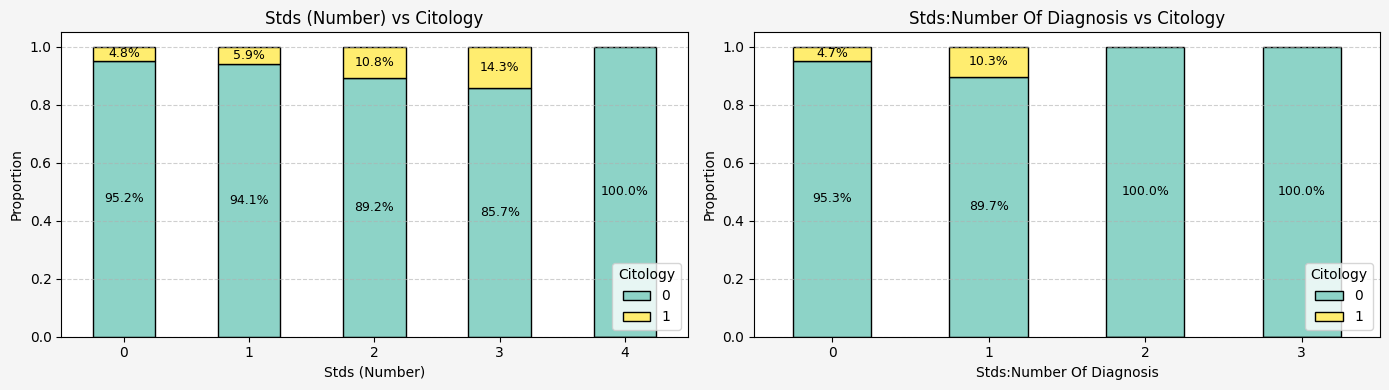

In [81]:
# Lets try stacked barplots again, to observe potential differences across the target subclasses
# Set up grid layout
n_cols = 2
n_rows = (len(discrete_low_card) + 1) // n_cols
plt.figure(figsize=(14, n_rows * 4), facecolor="whitesmoke")

# Generate stacked barplot for each feature
for i, feature in enumerate(discrete_low_card, 1):
    contingency = pd.crosstab(main_df[feature], main_df[target])
    proportions = contingency.div(contingency.sum(1), axis=0)

    ax = plt.subplot(n_rows, n_cols, i)
    bar_plot = proportions.plot(kind='bar', stacked=True, ax=ax, colormap="Set3", edgecolor='black')
    ax.set_title(f"{feature} vs {target}")
    ax.set_ylabel("Proportion")
    ax.set_xlabel(feature)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.legend(title=target, loc='lower right')
    plt.xticks(rotation=0)

    # Annotate percentages on each segment
    for container in bar_plot.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0.03:  # Avoid clutter for very small bars
                x = bar.get_x() + bar.get_width() / 2
                y = bar.get_y() + height / 2
                label = f"{height * 100:.1f}%"
                ax.text(x, y, label, ha='center', va='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()

In [82]:
# This time fewer and less powerfull differences can be observed
# Test for statistical significance of the differences observed:
# (I will use a Chi-Squared Test for Independence)

# Store results
chi2_results = []

# Perform chi-squared test for each discrete low-card feature
for feature in discrete_low_card:
    contingency = pd.crosstab(main_df[feature], main_df[target])
    stat, p, dof, expected = stats.chi2_contingency(contingency)

    chi2_results.append({
        "Feature": feature,
        "Chi2 Stat": stat,
        "p-value": p,
        "Significant (p < 0.05)": "Yes" if p < 0.05 else "No"
    })

# Convert to DataFrame
chi2_df = pd.DataFrame(chi2_results).set_index("Feature").sort_values("p-value")
chi2_df


Chi2 Stat   p-value Significant (p < 0.05)
Feature                                                             
Stds:Number Of Diagnosis   4.079276  0.253030                     No
Stds (Number)              3.886650  0.421563                     No

####

### 5.3.3 - Finally lets test the binary feature group with this target:

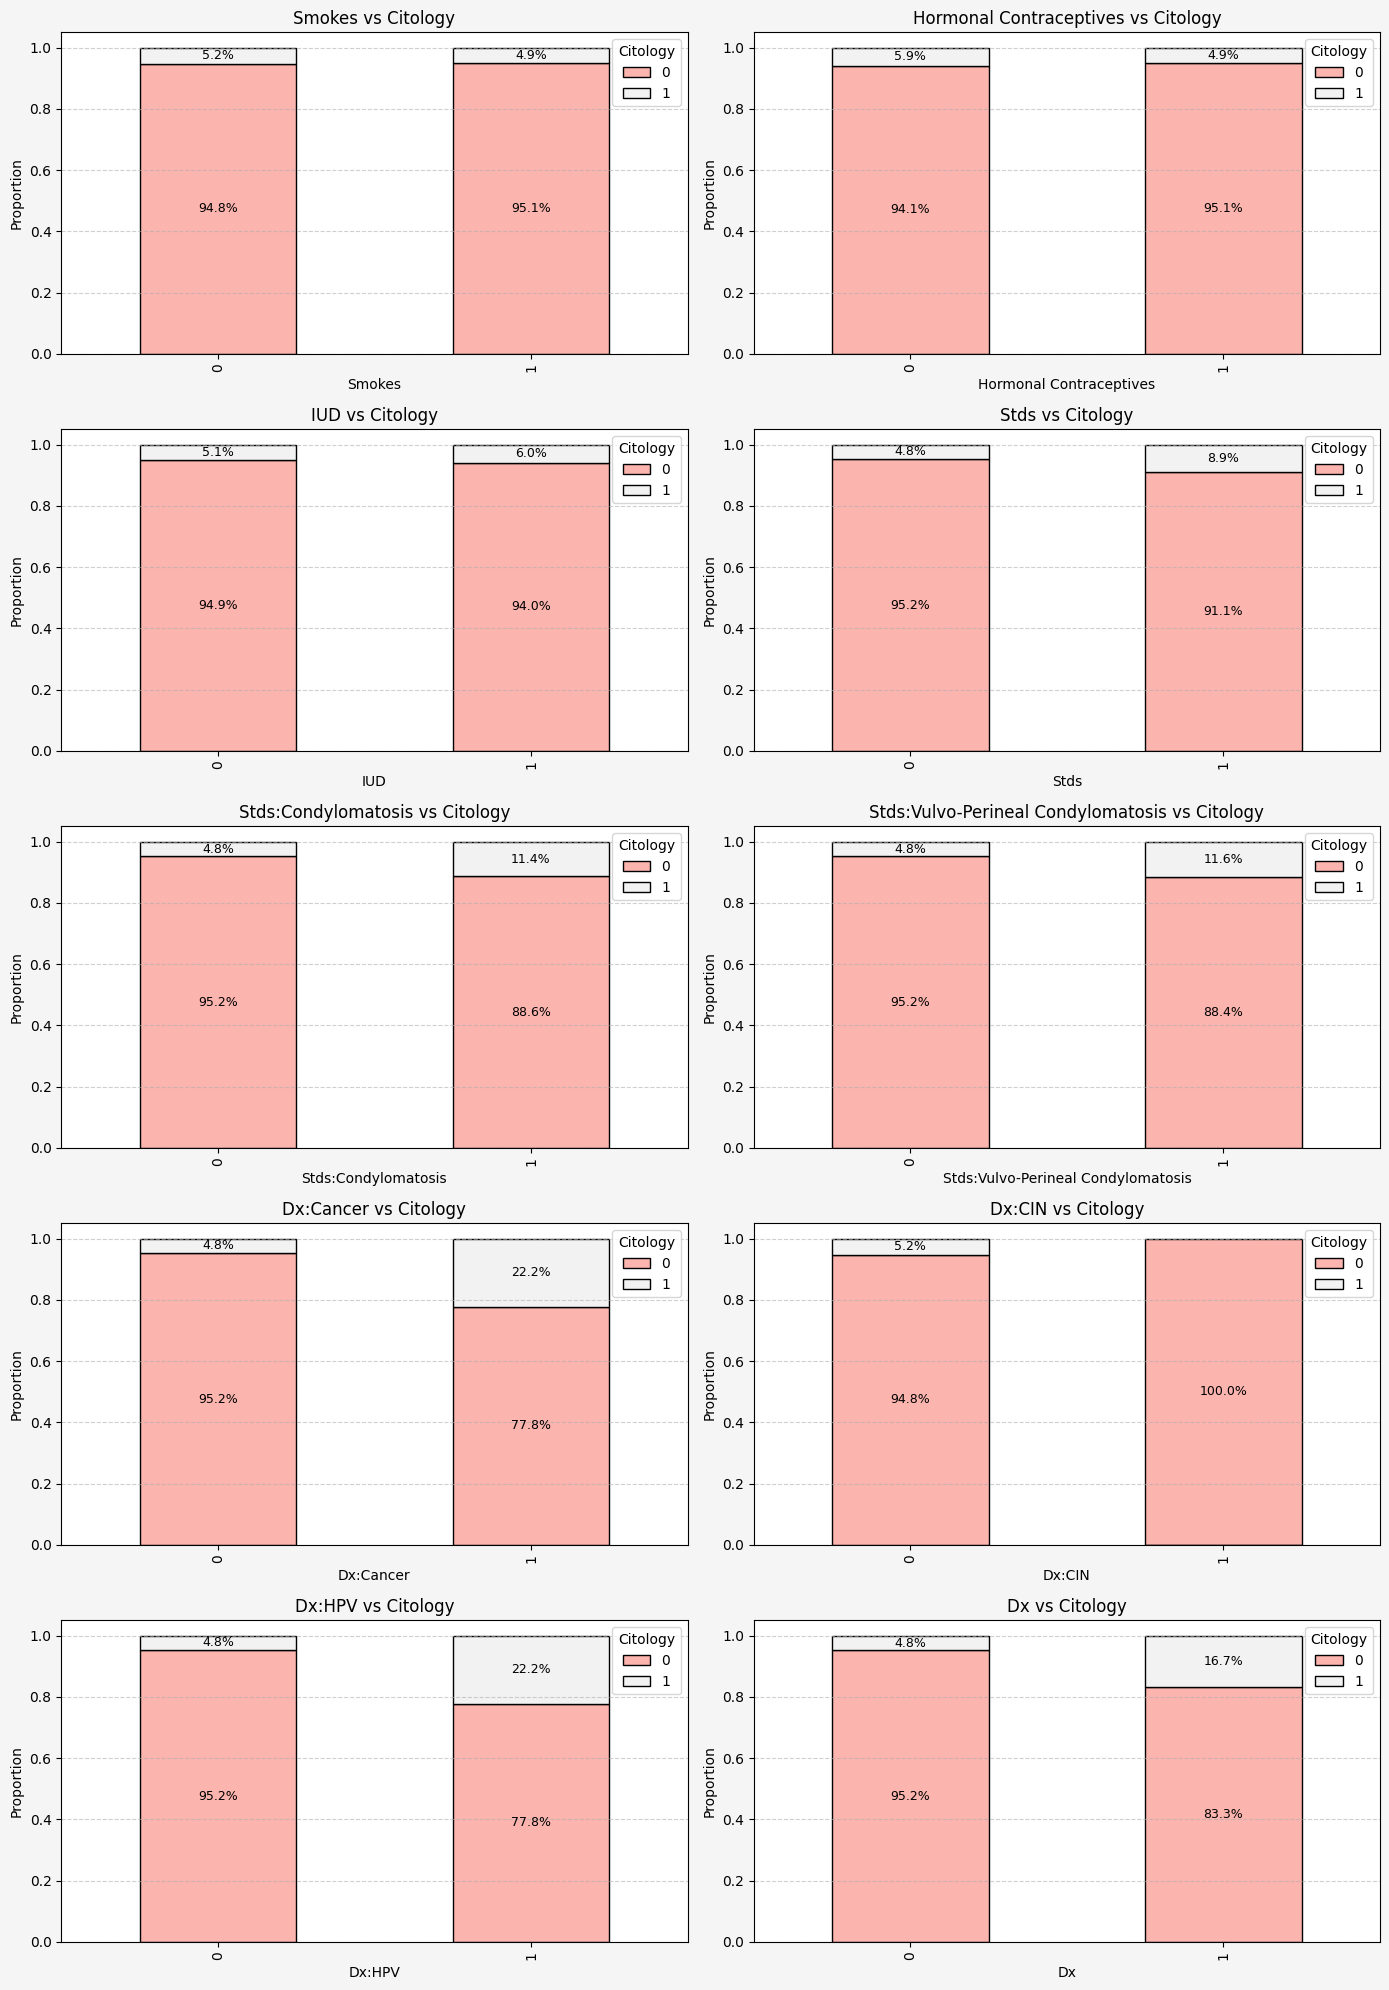

In [83]:
# Stacked barplots:
# Set up subplot layout
n_cols = 2
n_rows = (len(binary_features) + 1) // n_cols
plt.figure(figsize=(14, n_rows * 4), facecolor="whitesmoke")

# Loop through each binary feature and plot stacked bars
for i, feature in enumerate(binary_features, 1):
    contingency = pd.crosstab(main_df[feature], main_df[target])
    proportions = contingency.div(contingency.sum(1), axis=0)

    ax = plt.subplot(n_rows, n_cols, i)
    bar_plot = proportions.plot(kind='bar', stacked=True, ax=ax, colormap="Pastel1", edgecolor='black')
    ax.set_title(f"{feature} vs {target}")
    ax.set_ylabel("Proportion")
    ax.set_xlabel(feature)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.legend(title=target, loc='upper right')
    plt.xticks(rotation=0)

    # Annotate bar segments with percentages
    for container in bar_plot.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0.03:
                x = bar.get_x() + bar.get_width() / 2
                y = bar.get_y() + height / 2
                label = f"{height * 100:.1f}%"
                ax.text(x, y, label, ha='center', va='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()

In [84]:
# Once again, lets test for statistical significance
# Run Chi-squared tests and collect results
chi2_results_binary = []

for feature in binary_features:
    contingency = pd.crosstab(main_df[feature], main_df[target])
    stat, p, dof, expected = stats.chi2_contingency(contingency)

    chi2_results_binary.append({
        "Feature": feature,
        "Chi2 Stat": stat,
        "p-value": p,
        "Significant (p < 0.05)": "Yes" if p < 0.05 else "No"
    })

# Display results
chi2_bin_df = pd.DataFrame(chi2_results_binary).set_index("Feature").sort_values("p-value")
chi2_bin_df

Chi2 Stat   p-value Significant (p < 0.05)
Feature                                                                       
Dx:Cancer                            7.620321  0.005771                    Yes
Dx:HPV                               7.620321  0.005771                    Yes
Dx                                   4.447994  0.034942                    Yes
Stds:Vulvo-Perineal Condylomatosis   2.577954  0.108362                     No
Stds:Condylomatosis                  2.408853  0.120651                     No
Stds                                 1.650285  0.198920                     No
Hormonal Contraceptives              0.207668  0.648602                     No
IUD                                  0.010901  0.916847                     No
Dx:CIN                               0.000000  1.000000                     No
Smokes                               0.000000  1.000000                     No

#### Quite few statistically significant differences obsserved here, as well.

####

#### 5.4.1 - Next target: the Hinselmann variable

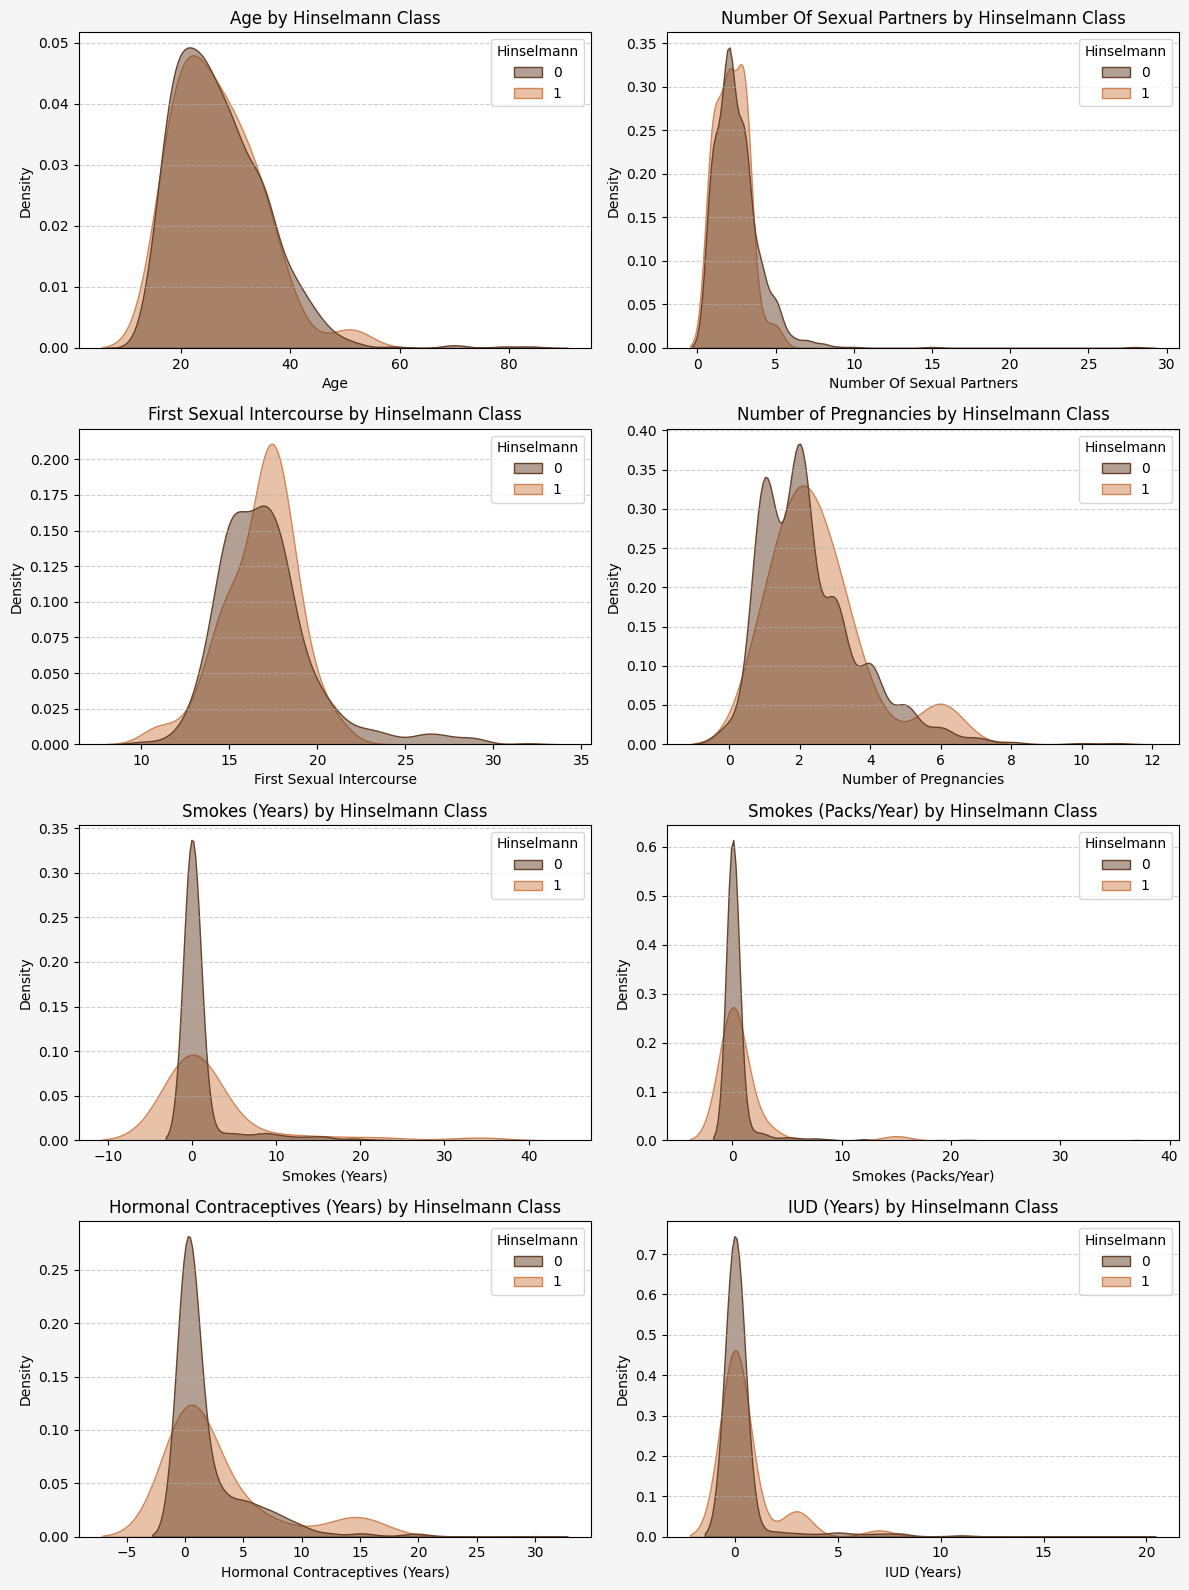

In [85]:
# Lets start with KDE plots again, following the same approach and order 
# This will be the discrete_high_card columns, the continuous/high-cardinality features once again, to start
# Choose target to explore
target = "Hinselmann"

# Plot KDEs 
n_cols = 2
n_rows = (len(discrete_high_card) + 1) // n_cols
plt.figure(figsize=(12, n_rows * 4), facecolor="whitesmoke")

for i, col in enumerate(discrete_high_card, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.kdeplot(data=main_df, x=col, hue=target, fill=True, common_norm=False, palette="copper", alpha=0.5)
    plt.title(f"{col} by {target} Class")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

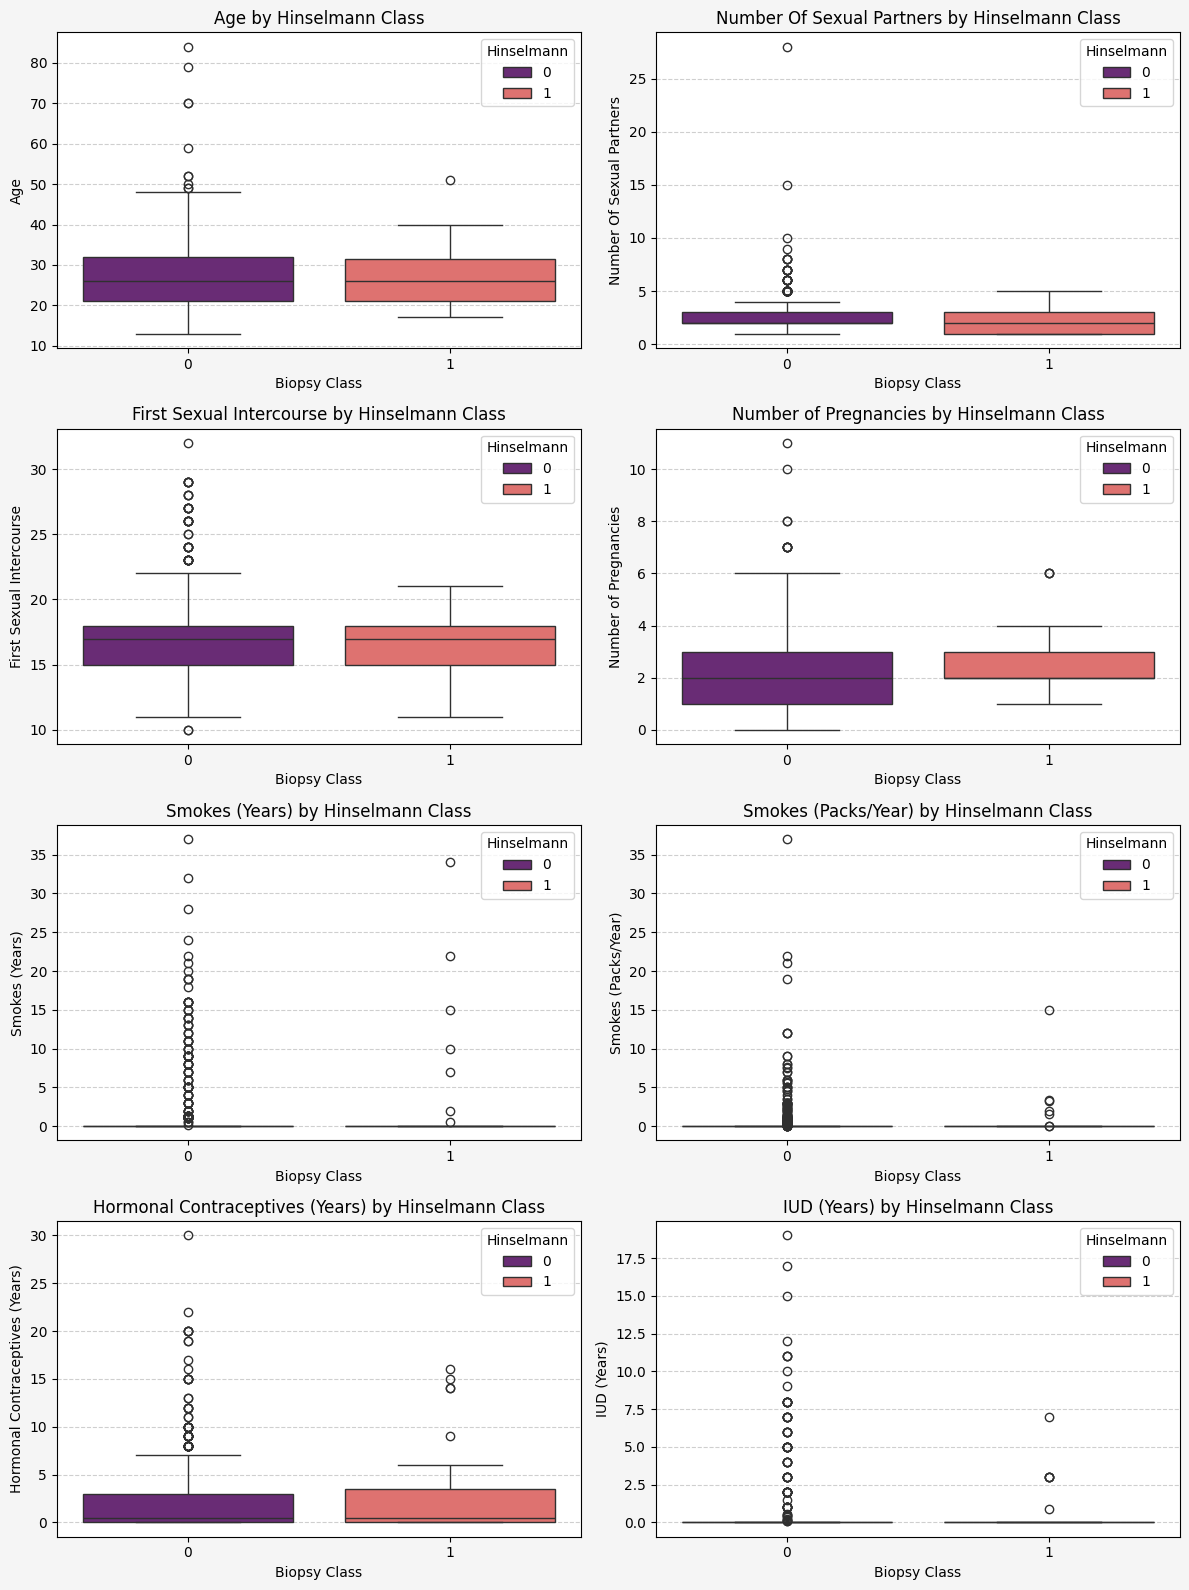

In [86]:
# Lets also generate some boxplots per target subclass, for these variables
# Plot boxplots
n_cols = 2
n_rows = (len(discrete_high_card) + 1) // n_cols
plt.figure(figsize=(12, n_rows * 4), facecolor="whitesmoke")

for i, col in enumerate(discrete_high_card, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=main_df, x=target, hue=target, y=col, palette="magma")
    plt.title(f"{col} by {target} Class")
    plt.xlabel("Biopsy Class")
    plt.ylabel(col)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


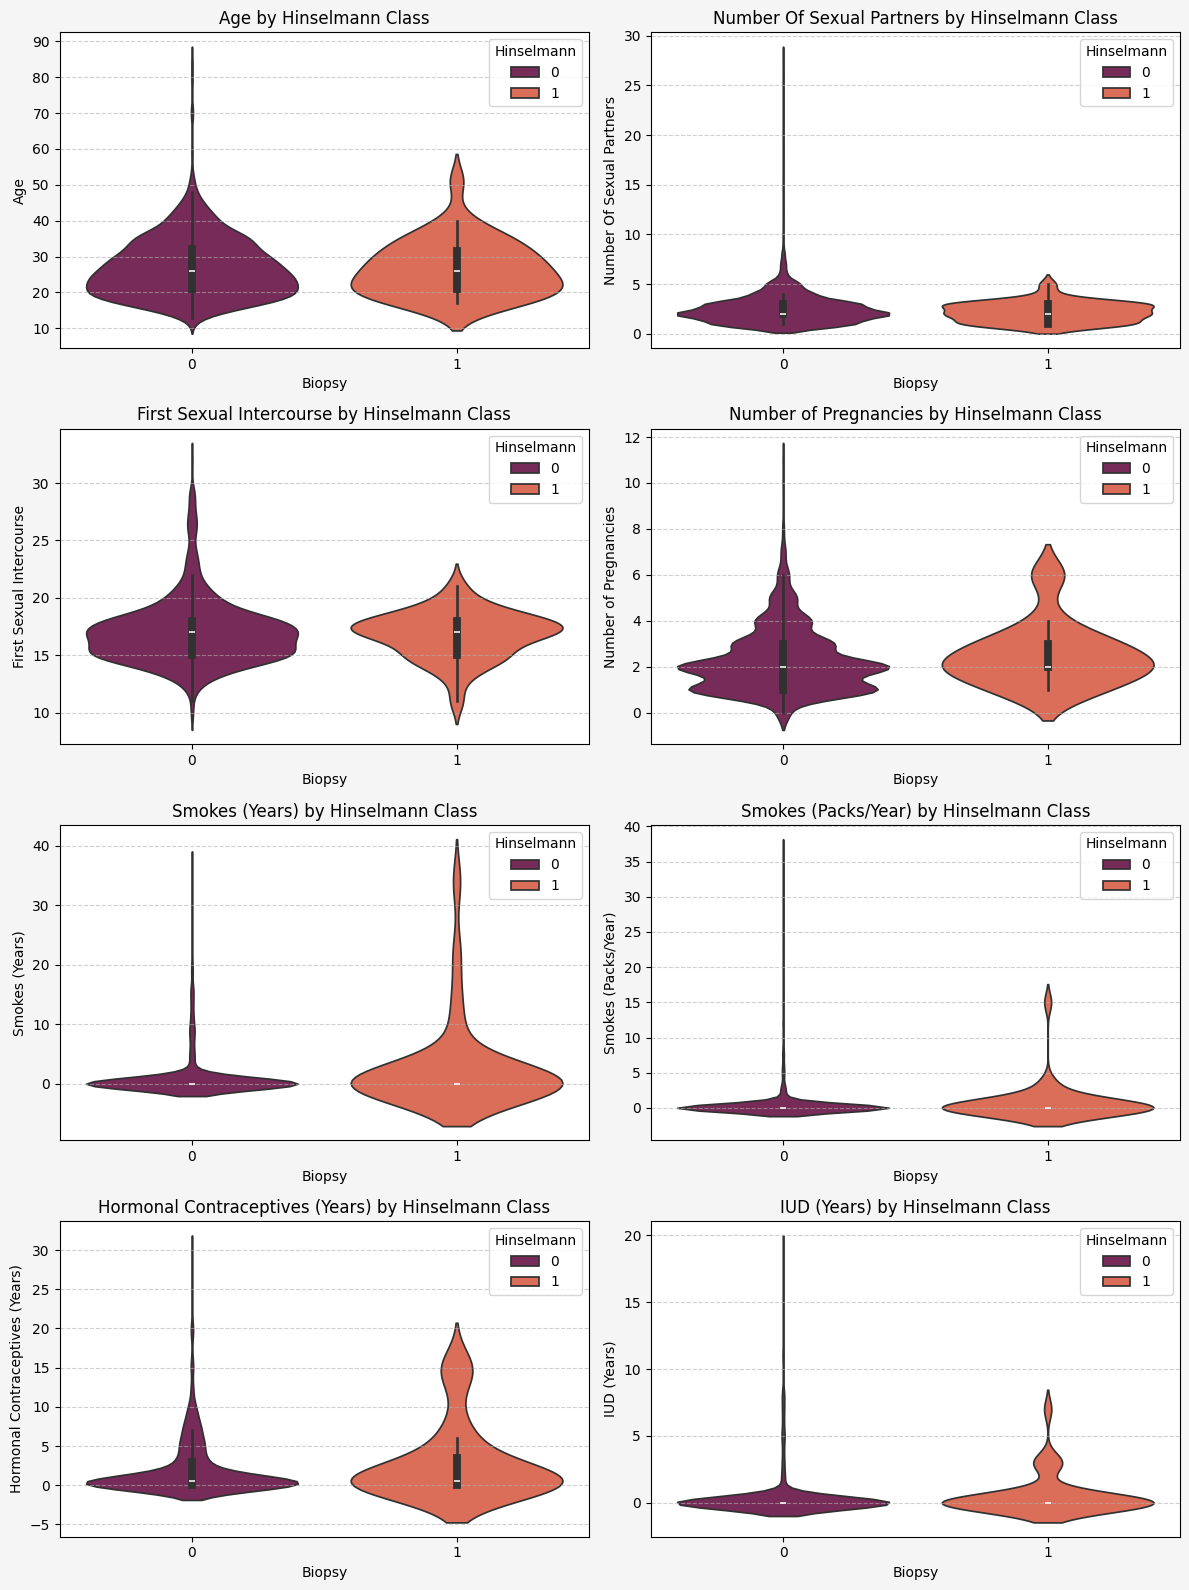

In [87]:
# And on to the violin plots
n_cols = 2
n_rows = (len(discrete_high_card) + 1) // n_cols
plt.figure(figsize=(12, n_rows * 4), facecolor="whitesmoke")

for i, col in enumerate(discrete_high_card, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.violinplot(data=main_df, x=target, hue=target, y=col, palette="rocket", inner="box")
    plt.title(f"{col} by {target} Class")
    plt.xlabel("Biopsy")
    plt.ylabel(col)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [88]:
# Again, we can notice some similarities with the previous low-impact results we got from these features
# I will perform Mann-Whitney U Tests once again, to locate any potential statistical significance

# Manually define features to test — include all continuous + borderline ones
features_to_test = [
    'Age',
    'Number Of Sexual Partners',
    'First Sexual Intercourse',
    'Number of Pregnancies',
    'Smokes (Years)',
    'Smokes (Packs/Year)',
    'Hormonal Contraceptives (Years)',
    'IUD (Years)'
]

# Store results
mann_whitney_results = []

for feature in features_to_test:
    group_0 = main_df[main_df[target] == 0][feature]
    group_1 = main_df[main_df[target] == 1][feature]
    
    stat, p = stats.mannwhitneyu(group_0, group_1, alternative='two-sided')
    
    mann_whitney_results.append({
        'Feature': feature,
        'U Statistic': stat,
        'p-value': p,
        'Significant (p < 0.05)': 'Yes' if p < 0.05 else ('Borderline' if p < 0.10 else 'No')
    })

# Display as DataFrame
results_df = pd.DataFrame(mann_whitney_results).sort_values('p-value')
results_df.set_index('Feature', inplace=True)

# Show result
results_df

U Statistic   p-value Significant (p < 0.05)
Feature                                                                      
IUD (Years)                          12908.0  0.164711                     No
Number of Pregnancies                12184.0  0.195592                     No
Number Of Sexual Partners            15289.0  0.303959                     No
Smokes (Years)                       13072.5  0.327787                     No
Smokes (Packs/Year)                  13132.0  0.363232                     No
Hormonal Contraceptives (Years)      13170.0  0.586680                     No
First Sexual Intercourse             13366.0  0.690918                     No
Age                                  14232.5  0.817806                     No

####

### 5.4.2 - Lets continue with the Hinselmann target and the low cardinality discrete value group:

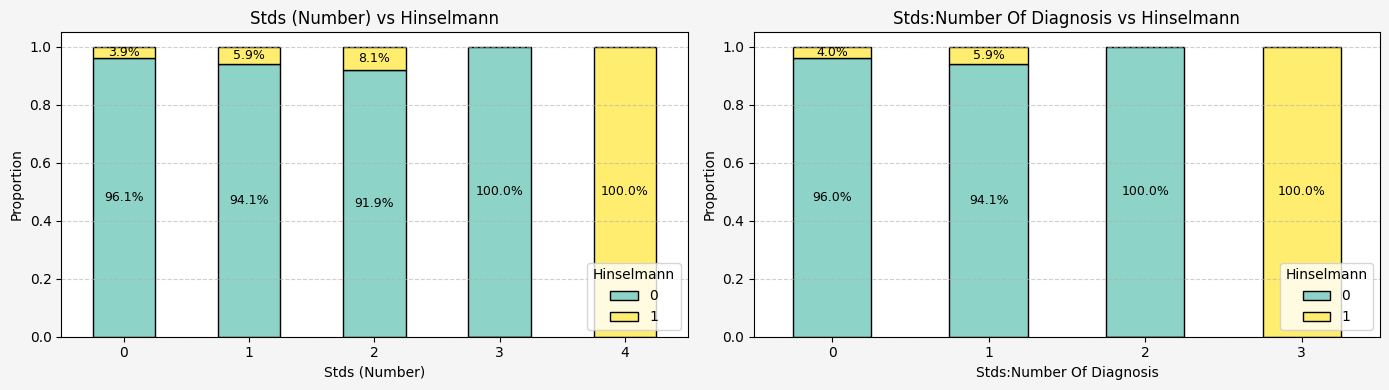

In [89]:
# Lets try stacked barplots again, to observe potential differences across the target subclasses
# Set up grid layout
n_cols = 2
n_rows = (len(discrete_low_card) + 1) // n_cols
plt.figure(figsize=(14, n_rows * 4), facecolor="whitesmoke")

# Generate stacked barplot for each feature
for i, feature in enumerate(discrete_low_card, 1):
    contingency = pd.crosstab(main_df[feature], main_df[target])
    proportions = contingency.div(contingency.sum(1), axis=0)

    ax = plt.subplot(n_rows, n_cols, i)
    bar_plot = proportions.plot(kind='bar', stacked=True, ax=ax, colormap="Set3", edgecolor='black')
    ax.set_title(f"{feature} vs {target}")
    ax.set_ylabel("Proportion")
    ax.set_xlabel(feature)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.legend(title=target, loc='lower right')
    plt.xticks(rotation=0)

    # Annotate percentages on each segment
    for container in bar_plot.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0.03:  # Avoid clutter for very small bars
                x = bar.get_x() + bar.get_width() / 2
                y = bar.get_y() + height / 2
                label = f"{height * 100:.1f}%"
                ax.text(x, y, label, ha='center', va='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()

In [90]:
# Here we can once again see some strong differences, clustered towards the larger Stds numbers
# Test for statistical significance of the differences observed:
# (I will use a Chi-Squared Test for Independence)

# Store results
chi2_results = []

# Perform chi-squared test for each discrete low-card feature
for feature in discrete_low_card:
    contingency = pd.crosstab(main_df[feature], main_df[target])
    stat, p, dof, expected = stats.chi2_contingency(contingency)

    chi2_results.append({
        "Feature": feature,
        "Chi2 Stat": stat,
        "p-value": p,
        "Significant (p < 0.05)": "Yes" if p < 0.05 else "No"
    })

# Convert to DataFrame
chi2_df = pd.DataFrame(chi2_results).set_index("Feature").sort_values("p-value")
chi2_df

Chi2 Stat   p-value Significant (p < 0.05)
Feature                                                             
Stds:Number Of Diagnosis  23.400596  0.000033                    Yes
Stds (Number)             24.877817  0.000053                    Yes

####

### 5.4.3 - Finally lets test the binary feature group with this target:

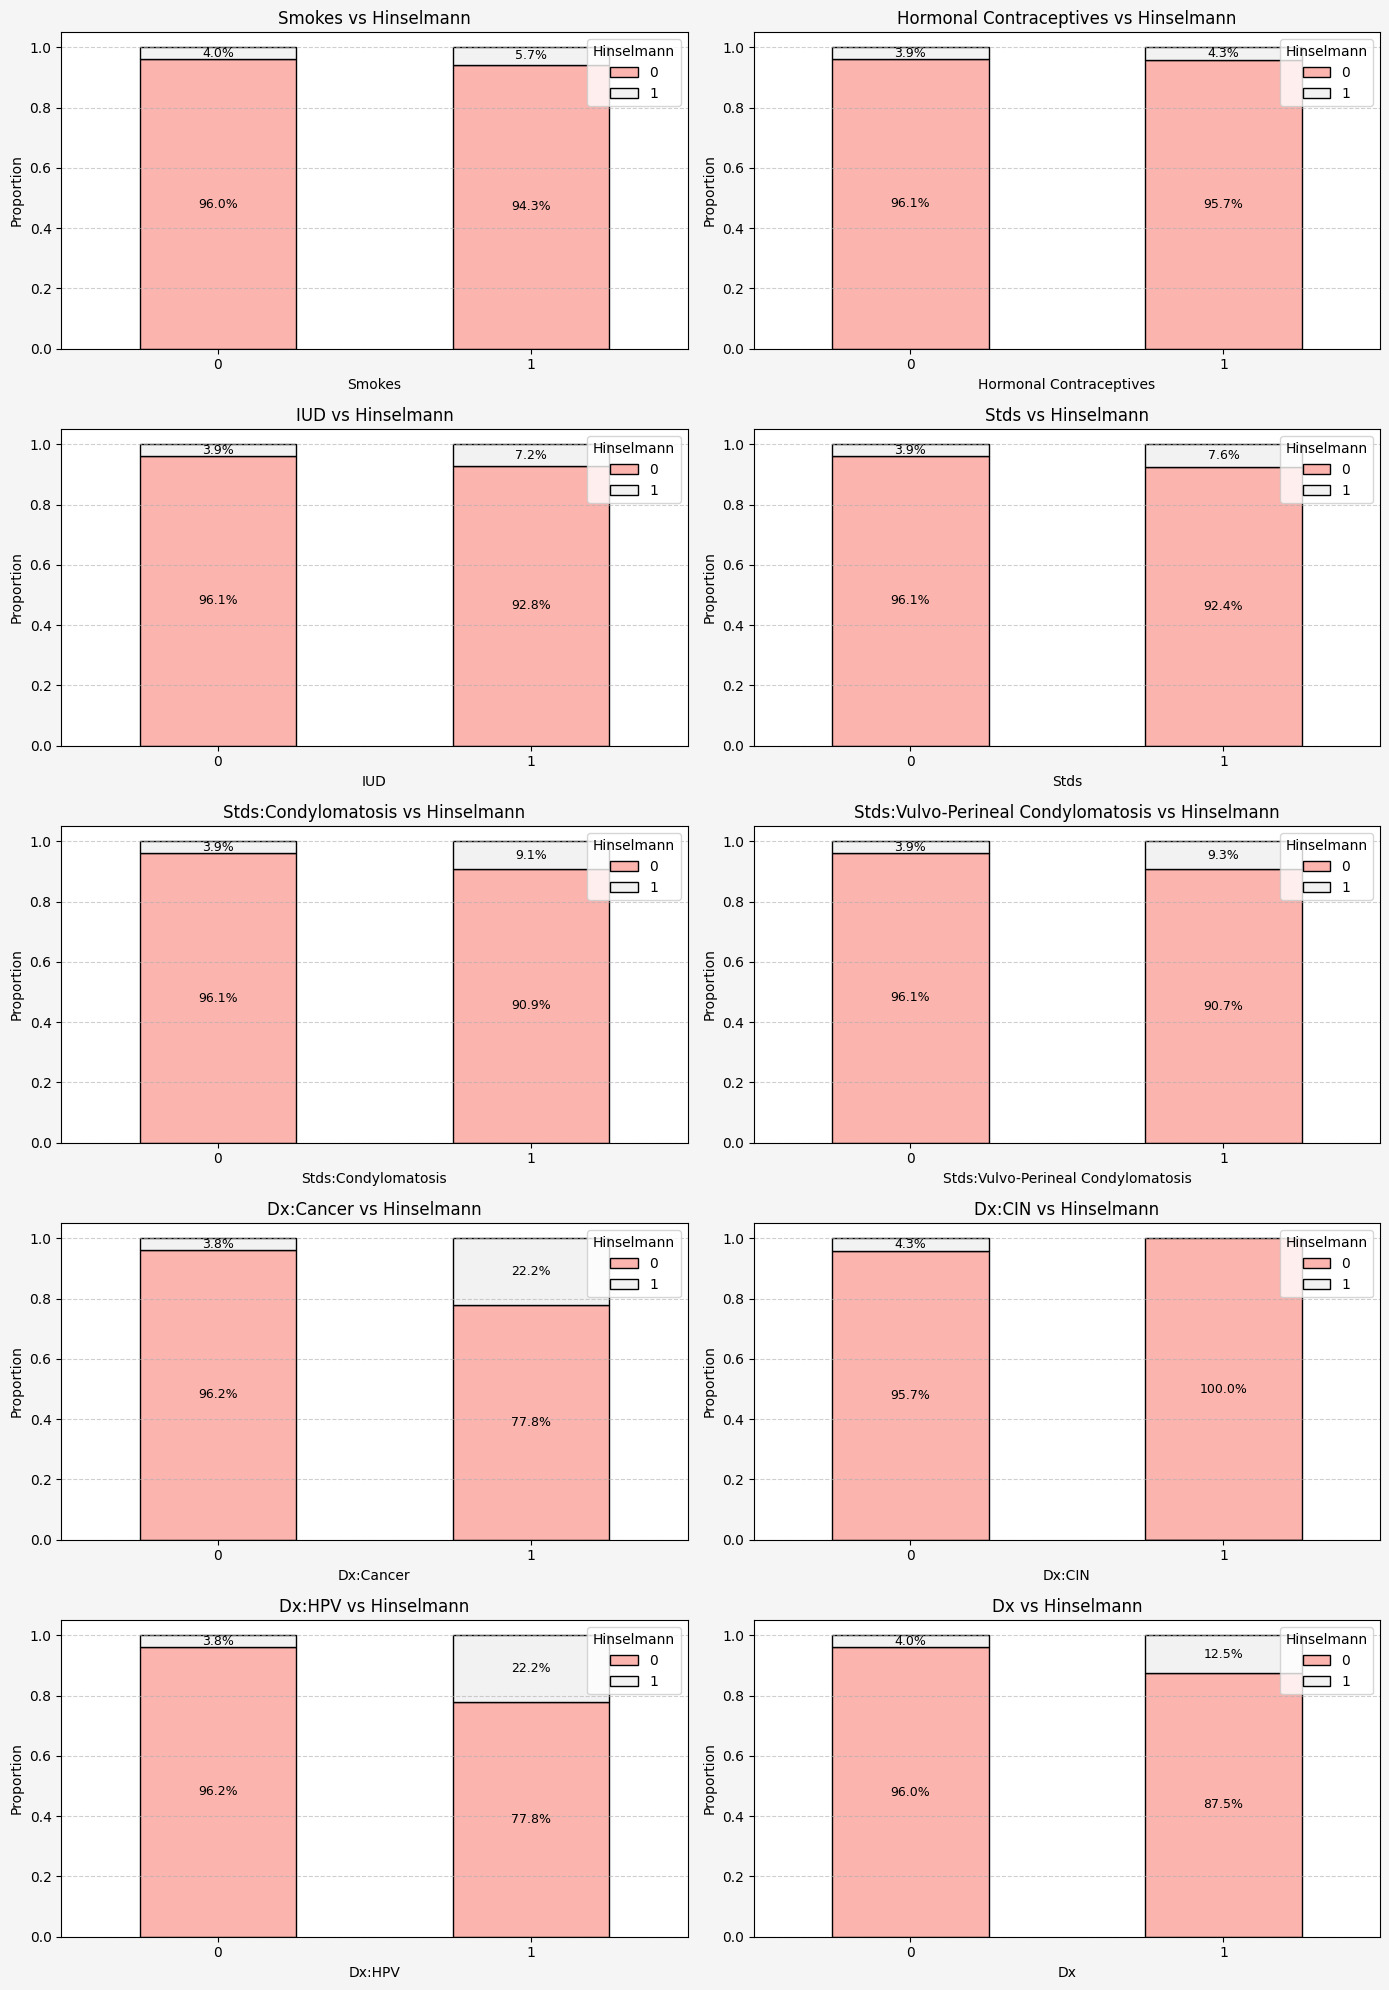

In [92]:
# Stacked barplots:
# Set up subplot layout
n_cols = 2
n_rows = (len(binary_features) + 1) // n_cols
plt.figure(figsize=(14, n_rows * 4), facecolor="whitesmoke")

# Loop through each binary feature and plot stacked bars
for i, feature in enumerate(binary_features, 1):
    contingency = pd.crosstab(main_df[feature], main_df[target])
    proportions = contingency.div(contingency.sum(1), axis=0)

    ax = plt.subplot(n_rows, n_cols, i)
    bar_plot = proportions.plot(kind='bar', stacked=True, ax=ax, colormap="Pastel1", edgecolor='black')
    ax.set_title(f"{feature} vs {target}")
    ax.set_ylabel("Proportion")
    ax.set_xlabel(feature)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.legend(title=target, loc='upper right')
    plt.xticks(rotation=0)

    # Annotate bar segments with percentages
    for container in bar_plot.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0.03:
                x = bar.get_x() + bar.get_width() / 2
                y = bar.get_y() + height / 2
                label = f"{height * 100:.1f}%"
                ax.text(x, y, label, ha='center', va='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()

In [93]:
# Once again, lets test for statistical significance
# Run Chi-squared tests and collect results
chi2_results_binary = []

for feature in binary_features:
    contingency = pd.crosstab(main_df[feature], main_df[target])
    stat, p, dof, expected = stats.chi2_contingency(contingency)

    chi2_results_binary.append({
        "Feature": feature,
        "Chi2 Stat": stat,
        "p-value": p,
        "Significant (p < 0.05)": "Yes" if p < 0.05 else "No"
    })

# Display results
chi2_bin_df = pd.DataFrame(chi2_results_binary).set_index("Feature").sort_values("p-value")
chi2_bin_df

Chi2 Stat   p-value Significant (p < 0.05)
Feature                                                                       
Dx:Cancer                           10.562755  0.001154                    Yes
Dx:HPV                              10.562755  0.001154                    Yes
Dx                                   2.351963  0.125125                     No
Stds:Vulvo-Perineal Condylomatosis   1.727650  0.188711                     No
Stds                                 1.628999  0.201842                     No
Stds:Condylomatosis                  1.607063  0.204905                     No
IUD                                  1.325746  0.249563                     No
Smokes                               0.407541  0.523220                     No
Hormonal Contraceptives              0.006244  0.937018                     No
Dx:CIN                               0.000000  1.000000                     No

####

### Final remarks for the EDA phase:

#### We can observe features that show significant differences across the four targets and their subclasses, but also features that don't seem promising in every target variable. The KDE plots helped us identify distribution shifts among the features, and the boxplots along with the violin plots are a great complementary way to search for IQR, median, range and density differences among the classes.

#### Separating the features into three distinct groups according to their numericcal/value nature was also helpful, because it enabled us to use appropriate visualizations for each occasion. Stacked barplots with calculated proportions for each target subclass are a great way to visualize potential class differences, and of course the additional statistical tests are a way to validate visual findings.

#### Examining the graphs and also taking into account the results of the Mann-Whitney U Tests and Chi-Squared Tests, my strategy will be the following:

#### I will separate those I consider to be the most statistically significant features for each target, and create separate model-ready datasets which will be subsequently saved, and kept so they can be used in the last modelling phase of this project. At this point I choose not to proceed with dimensionality reduction and further feature selection, except for the approach already mentioned.

####

#### These are the features which I consider to be significant predictors, for each repsective target variable:

In [95]:
# For the Biopsy target:
biopsy_cols = ['Citology', 'Dx', 'Dx:CIN', 'Dx:Cancer', 'Dx:HPV', 
               'Hinselmann', 'Schiller', 'Stds', 'Stds (Number)', 
               'Stds:Condylomatosis', 'Stds:Number Of Diagnosis', 
               'Stds:Vulvo-Perineal Condylomatosis']

# For the Schiller target:
schiller_cols = ['Age', 'Biopsy', 'Citology', 'Dx', 'Dx:Cancer', 'Dx:HPV', 
                 'Hinselmann', 'IUD', 'IUD (Years)', 'Number of Pregnancies', 
                 'Stds', 'Stds (Number)', 'Stds:Condylomatosis', 
                 'Stds:Number Of Diagnosis', 'Stds:Vulvo-Perineal Condylomatosis']

# For the Hinselmann target:
hinselmann_cols = ['Biopsy', 'Citology', 'Dx:Cancer', 'Dx:HPV', 
                   'Schiller', 'Stds (Number)', 'Stds:Number Of Diagnosis']

# For the Citology target:
citology_cols = ['Biopsy', 'Dx', 'Dx:Cancer', 'Dx:HPV', 
                 'Hinselmann', 'Schiller']


#### This will create and save the model-ready datasets before we move on to the next phase:

In [96]:
# Dictionary of statistically significant features per target
promising_features_by_target = {
    "Biopsy": ['Citology', 'Dx', 'Dx:CIN', 'Dx:Cancer', 'Dx:HPV', 'Hinselmann', 'Schiller', 'Stds', 'Stds (Number)',
               'Stds:Condylomatosis', 'Stds:Number Of Diagnosis','Stds:Vulvo-Perineal Condylomatosis'],
    "Schiller": ['Age', 'Biopsy', 'Citology', 'Dx', 'Dx:Cancer', 'Dx:HPV', 'Hinselmann', 'IUD', 'IUD (Years)', 'Number of Pregnancies',
                 'Stds', 'Stds (Number)', 'Stds:Condylomatosis', 'Stds:Number Of Diagnosis', 'Stds:Vulvo-Perineal Condylomatosis'],
    "Hinselmann": ['Biopsy', 'Citology', 'Dx:Cancer', 'Dx:HPV', 'Schiller', 'Stds (Number)', 'Stds:Number Of Diagnosis'],
    
    "Citology": ['Biopsy', 'Dx', 'Dx:Cancer', 'Dx:HPV', 'Hinselmann', 'Schiller']}

# Create and save datasets
for target, features in promising_features_by_target.items():
    # Add target to feature list
    selected_cols = features + [target]
    model_df = main_df[selected_cols].copy()

    # Save to CSV
    filename = f"model_ready_{target.lower()}.csv"
    model_df.to_csv(filename, index=False)
    print(f"Saved: {filename}")


Saved: model_ready_biopsy.csv
Saved: model_ready_schiller.csv
Saved: model_ready_hinselmann.csv
Saved: model_ready_citology.csv
